In [1]:
# pip installs
# !pip install openpyxl

# imports
import pandas as pd
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

2024-10-23 09:08:58.993553: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 09:08:58.999412: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-23 09:08:59.017264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 09:08:59.043738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 09:08:59.051617: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 09:08:59.074445: I tensorflow/core/platform/cpu_feature_gu

# Problem Formulation

Unemployment is one of the critical economic indicators that reflects the health of an economy and the well-being of its labour force. It is commonly used by policy makers and economistcs to assess labour market conditions and guide decisions related to ficsal and monetary policies.

The goal of this notebook is to utilise Queensland Labour Force data to explore historial trends and build a forecasting model to predict future unemployment rates. Providing insights into the evolution of unemployment in Queensland and the potential trajectory, offering valuable information to government officials and economists.

# 1. Data Preparation

Three datasets have been provided: 
1. Unemployement data, collected by the Australian Bureau of Statistics.
2. Inflation data, also collected by the Australian Bureau of Statistics.
3. Interest rates, published by the Reserve Bank of Australia (RBA).

To being the data prepartion processes, all relevant data will be compiled for the period of 2011 to 2023 into one dataframe. And will be indexed accordingly to suit timeseries analysis.


Dataset 1, the unemployement data, has a range of series. As the interest of this analysis is on Queensland, relevant data from this set will be under **Series ID A84423620T**, titled “Unemployment rate ; Persons ; Percent Original”. This data is collected montly.

Dataset 2, the inflation data, is also comprised of several series. Thus, for this analysis data from **Series ID A2325846C**, titled “Index Numbers ; All groups CPI ; Australia ; Index Numbers Original” will be used. This data is collected quarterly.

Dataset 3, the interest rates data will specifically use the **Series ID FIRMMCRTD**, titled "Cash Rate Target on date, Daily, Original". Collected daily

In [2]:
# Load the datasets
unemploy_data = pd.read_excel("6202006.xlsx", sheet_name="Data1")
inflation_data = pd.read_excel("640101.xlsx", sheet_name="Data1")
interRate_data = pd.read_excel("f01d.xlsx", sheet_name="Data")

# UNEMPLOYMENT DATASET
unemploy_column_data = unemploy_data.iloc[:, 48]
filtered_unemploy_column_data = unemploy_column_data.iloc[9:]
dates = unemploy_data.iloc[9:, 0]
dates = pd.to_datetime(dates, format='%Y-%m-%d', errors='coerce')
new_unemploy_df = pd.DataFrame(filtered_unemploy_column_data)
new_unemploy_df.index = dates
new_unemploy_df.columns = ["Unemployment Rate"]
new_unemploy_df.to_csv("unemployed_data.csv", index=True)

# INFLATION DATASET
inflat_column_data = inflation_data.iloc[:, 9]
filtered_inflat_column_data = inflat_column_data.iloc[9:]  # Corrected to use inflation data
dates2 = inflation_data.iloc[9:, 0]
dates2 = pd.to_datetime(dates2, format='%Y-%m-%d', errors='coerce')  # Corrected to use dates2
new_inflat_df = pd.DataFrame(filtered_inflat_column_data)
new_inflat_df.index = dates2
new_inflat_df.columns = ["Inflation Rate"]
new_inflat_df.to_csv("inflation_data.csv")

# INTEREST RATE DATASET
interRate_column_data = interRate_data.iloc[:, 1]
filtered_interRate_column_data = interRate_column_data.iloc[10:]
dates3 = interRate_data.iloc[10:, 0]
dates3 = pd.to_datetime(dates3, format='%Y-%m-%d', errors='coerce')
new_interRate_df = pd.DataFrame(filtered_interRate_column_data)
new_interRate_df.index = dates3
new_interRate_df.columns = ["Interest Rate"]
new_interRate_df.to_csv("interestRate_data.csv")

# Reload the csv files with the collected information
unemployed_data = pd.read_csv("unemployed_data.csv", index_col=0, parse_dates=True)
inflation_data = pd.read_csv("inflation_data.csv", index_col=0, parse_dates=True)
interestRate_data = pd.read_csv("interestRate_data.csv", index_col=0, parse_dates=True)

# Combine the datasets
grouped_df = pd.concat([unemployed_data, inflation_data, interestRate_data], axis=1, join="outer")

# Sort the index in place
grouped_df.sort_index(inplace=True)

# Filter the DataFrame for the years 2011 to 2023
grouped_df = grouped_df.loc['2011':'2023']

# Display the first 16 rows
print(grouped_df.head(16))

            Unemployment Rate  Inflation Rate  Interest Rate
2011-01-01           6.096681             NaN            NaN
2011-01-04                NaN             NaN           4.75
2011-01-05                NaN             NaN           4.75
2011-01-06                NaN             NaN           4.75
2011-01-07                NaN             NaN           4.75
2011-01-10                NaN             NaN           4.75
2011-01-11                NaN             NaN           4.75
2011-01-12                NaN             NaN           4.75
2011-01-13                NaN             NaN           4.75
2011-01-14                NaN             NaN           4.75
2011-01-17                NaN             NaN           4.75
2011-01-18                NaN             NaN           4.75
2011-01-19                NaN             NaN           4.75
2011-01-20                NaN             NaN           4.75
2011-01-21                NaN             NaN           4.75
2011-01-24              

In [3]:
# Reload the csv files with the collected information
unemployed_data = pd.read_csv("unemployed_data.csv", index_col=0, parse_dates=True)
inflation_data = pd.read_csv("inflation_data.csv", index_col=0, parse_dates=True)
interestRate_data = pd.read_csv("interestRate_data.csv", index_col=0, parse_dates=True)

grouped_df = pd.concat([unemployed_data, inflation_data, interestRate_data], axis=1, join="outer")
grouped_df.sort_index(inplace=True)
grouped_df = grouped_df['2011':'2023']
grouped_df.index = pd.to_datetime(grouped_df.index, errors='coerce')

print(grouped_df.head(30))

            Unemployment Rate  Inflation Rate  Interest Rate
2011-01-01           6.096681             NaN            NaN
2011-01-04                NaN             NaN           4.75
2011-01-05                NaN             NaN           4.75
2011-01-06                NaN             NaN           4.75
2011-01-07                NaN             NaN           4.75
2011-01-10                NaN             NaN           4.75
2011-01-11                NaN             NaN           4.75
2011-01-12                NaN             NaN           4.75
2011-01-13                NaN             NaN           4.75
2011-01-14                NaN             NaN           4.75
2011-01-17                NaN             NaN           4.75
2011-01-18                NaN             NaN           4.75
2011-01-19                NaN             NaN           4.75
2011-01-20                NaN             NaN           4.75
2011-01-21                NaN             NaN           4.75
2011-01-24              

The 3 datasets have been compiled and combined into one series for the period of 2011-2023. The index of the combined data is date-time. As this data will be used for timeseries analysis, the index of the data must be in date-time format.

All datasets have a different value collection date. The unemployment rate dataset has monthly data. The inflation rate data has quartely collection (every 3 months). And the interestRate data has a daily collection rate, however only 5 days of the week (excluding weekends).

As the each dataset has a varying index, the current combined series has a lot of missing values. A method to fix this is to either upsample or down sample the data, or correlating all the data around one collection rate.


As the data is separated into daily, monthly, and quarterly data, sampling all the data to daily to match the interest rate data. This shouldn't affect any trends or seasonality within the data, since data that is collected monthly can just be used for the daily statistics of that month. Meaning that data loss is minimised while being adjusted to an equal resolution.


ORR

As the main data analysed in this notebook is the unemployment data, having all data matching the datetime indexing of the unemployment data won't skew or alter it. To adjust the resolution of the Interest Rate data a monthly mean will be used. This is to reduce the amount of data and information lost, allowing majority of it's individual trend and/or seasonality to still be present.

In [4]:
unified_grouped_df = grouped_df.resample('ME').mean()
unified_grouped_df.index = pd.to_datetime(unified_grouped_df.index).to_period('M').to_timestamp()
unified_grouped_df["Inflation Rate"] = unified_grouped_df["Inflation Rate"].bfill()

In [5]:
unified_grouped_df.head(16)

,Unemployment Rate,Inflation Rate,Interest Rate
2011-01-01,6.096681,98.3,4.750000
2011-02-01,6.500871,98.3,4.750000
2011-03-01,6.091718,98.3,4.750000
2011-04-01,5.247593,99.2,4.750000
2011-05-01,5.273783,99.2,4.750000
2011-06-01,5.051848,99.2,4.750000
2011-07-01,5.161525,99.8,4.750000
2011-08-01,5.736065,99.8,4.750000
2011-09-01,5.195414,99.8,4.750000
2011-10-01,5.116262,99.8,4.750000


# 2. Exploratory Data Analysis (EDA)

In [6]:
df = unified_grouped_df
df.index

DatetimeIndex(['2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', length=156, freq='MS')

In [7]:
df.isna().sum()

Unemployment Rate    0
Inflation Rate       0
Interest Rate        0
dtype: int64

The dataframe has no missing rows from the adjustment of the resolutions.

## Visualisation and Exploratory Analysis

We can plot the time series of the unemployment rates to assist in a baseline understanding of the nature of the data.

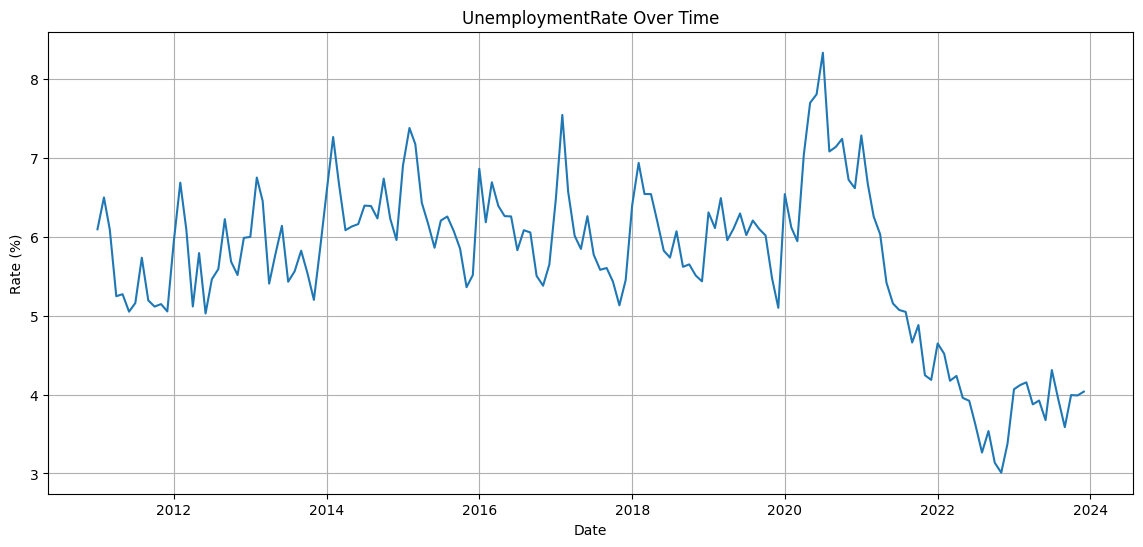

In [8]:
plt.figure(figsize=(14, 6))
plt.plot(df['Unemployment Rate'])

plt.title('UnemploymentRate Over Time')
plt.ylabel('Rate (%)')
plt.xlabel('Date')

plt.grid()
plt.show()

From the timeseries visualisation above, there is an obvious spike at the start of 2020. This can be infered to be due to a major health crisis and epidemic, rising the unemployment rate, and then reducing it dramaticaly into 2023.

There is a noticeable seasonality in the data as the beginning of each year jumps to higher unemployment rates. There are many possibilities for why this happens, one could be due to seasonal layoffs. A popular standard in many retail employement consists of highering more people during the months of novemeber/december, and this can be seen from the graph, as unemployment rate drops at the end of each year. Then the hugh rise in unemployment, comes from not requiring these workers. Another seasonality component is identified, as there is a slight spike in unemployement rate in the middle of some years, this could be due to end of financial year is the factor of this seasonality.

A trend in the data is the decline of unemployement rate in each year. Meaning that as the year goes on, unemployement decreases. Although, this could also be due to the seasonality of holiday hiring. 

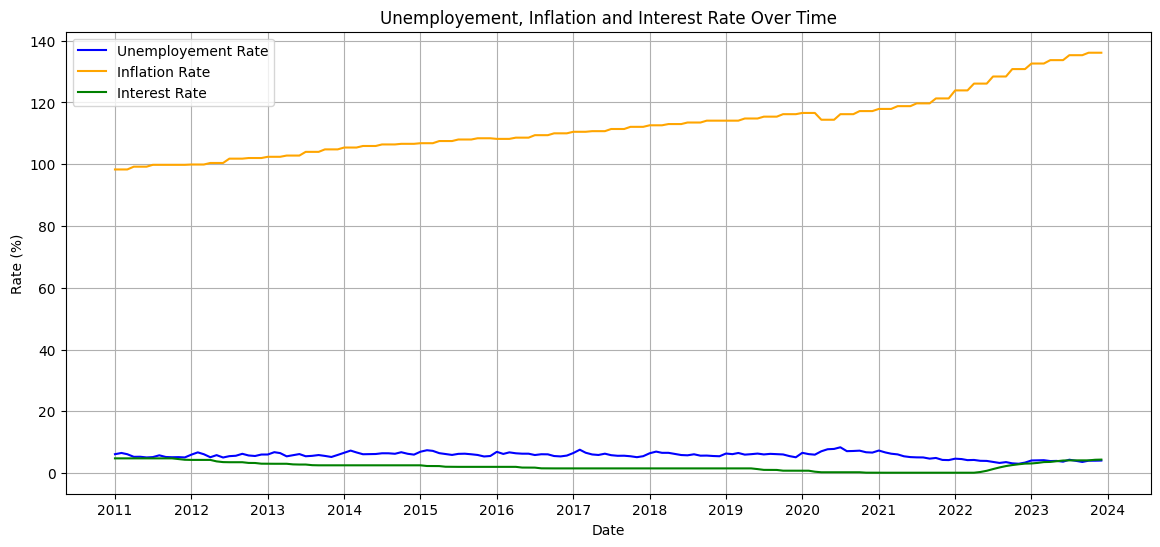

In [9]:
plt.figure(figsize=(14, 6))
plt.plot(df['Unemployment Rate'], label='Unemployement Rate', color='blue')
plt.plot(df['Inflation Rate'], label='Inflation Rate', color='orange')
plt.plot(df['Interest Rate'], label='Interest Rate', color='green')

plt.title('Unemployement, Inflation and Interest Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Rate (%)')

plt.gca().xaxis.set_major_locator(mdates.YearLocator(1))

plt.legend()
plt.grid()
plt.show()

The three datasets have been plotted onto the graph above. The inflation rate data is very different to the other datasets 
as it's rate values are significantly higher. This dataset is also not very smooth as it has lots of flat bumps and rises, however this was due to changing the resolution from quarterly to monthly and only interpolating the data with the previous point.

The interst rate data is the smoothest, as it was up sampled in resolution from daily to monthly, allowing the use of monthly averages to be plotted. This data is closer to the shape of the unemployment rate data and appears to slightly show that when interest date gradually decreased, the unemployment rate got choppier and more variable.

# 3. STR Decomposition

The timeseries data explored in the previous section can be separated into 3 components: Trend, Seasonality, and Residual, and with this more accurate forecasting models can be created. It will also allow a better visualisation of the componets within the timeseries data, which could've been distored or hiden in the previous visual analysis.

### Splitting the Data into Training and Test

In [10]:
training_end_date = '2021-02-01'
test_start_date = '2021-01-01'

train_df = df.loc[:training_end_date]
print(train_df.tail())

print()

test_df = df.loc[test_start_date:]
print(test_df.head(5))

            Unemployment Rate  Inflation Rate  Interest Rate
2020-10-01           7.243744           117.2       0.250000
2020-11-01           6.724992           117.2       0.114286
2020-12-01           6.617614           117.2       0.100000
2021-01-01           7.286519           117.9       0.100000
2021-02-01           6.669898           117.9       0.100000

            Unemployment Rate  Inflation Rate  Interest Rate
2021-01-01           7.286519           117.9            0.1
2021-02-01           6.669898           117.9            0.1
2021-03-01           6.258511           117.9            0.1
2021-04-01           6.032637           118.8            0.1
2021-05-01           5.422098           118.8            0.1


Now when forecasts are being predicted from this data, the training data can be used. And then tested against the test data to see how accurate the prediction is.

### 3.1 Isolate the Trend

To isolate the timeseries and decompose the trend, due to the data having a distinct yearly seasonality, a rolling average over this time period could be used.

<Axes: >

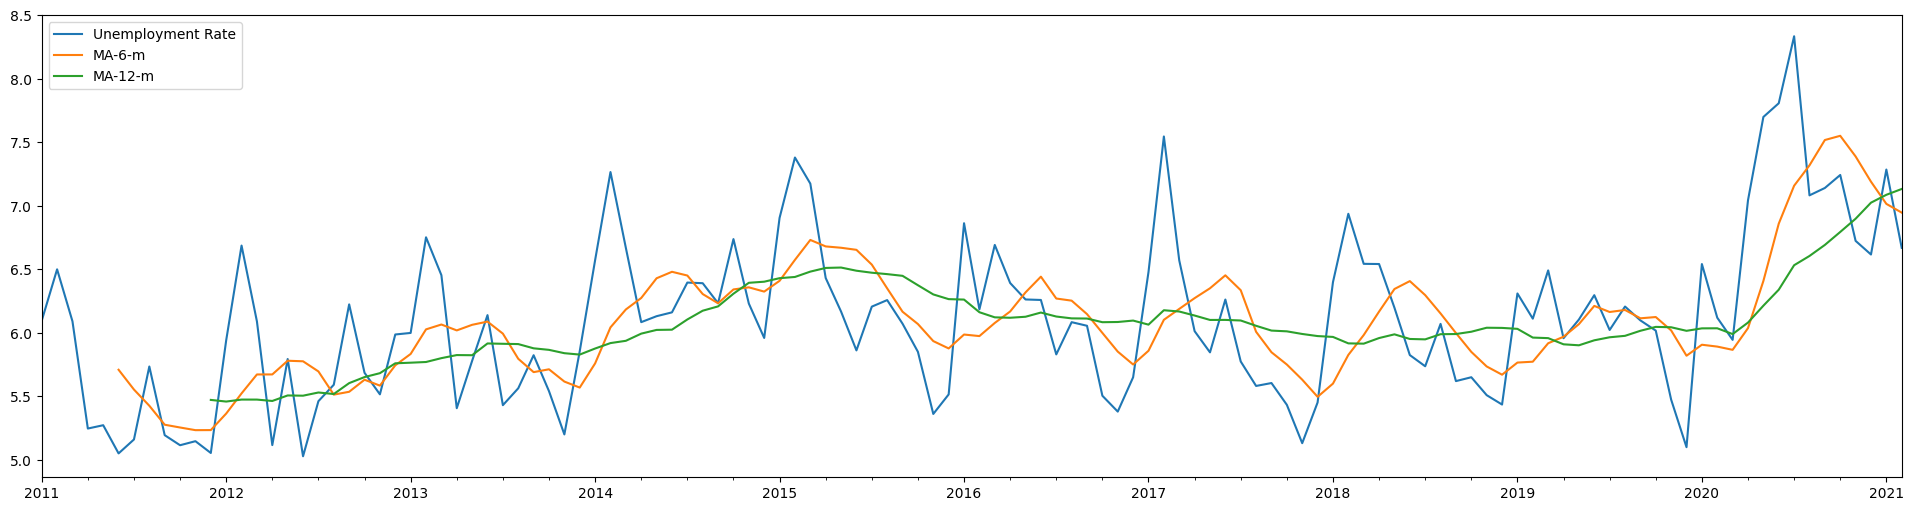

In [11]:
df2 = train_df.copy()

df2['MA-6-m'] = df2['Unemployment Rate'].rolling(6).mean()
df2['MA-12-m'] = df2['Unemployment Rate'].rolling(12).mean()

#, min_periods=1

df2[['Unemployment Rate', 'MA-6-m', 'MA-12-m']].plot(figsize=(24,6))

<Axes: >

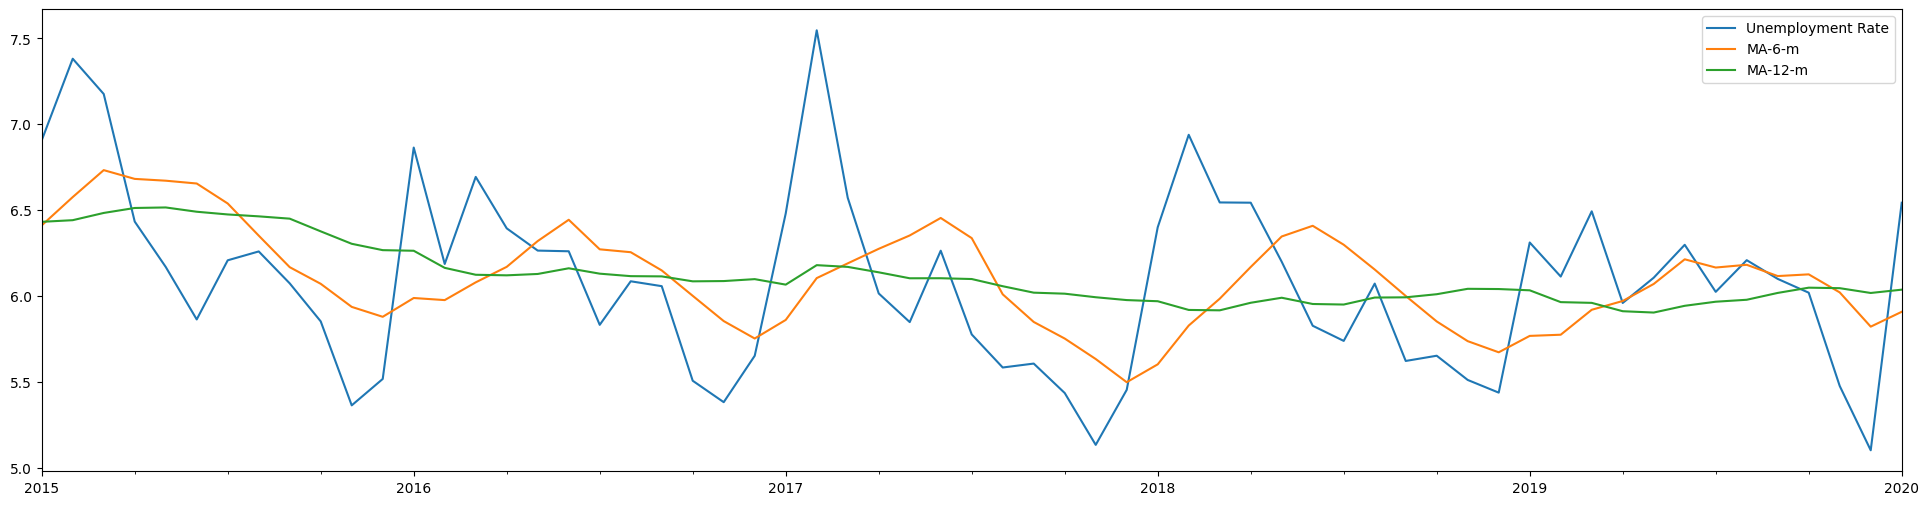

In [12]:
df2['2015-01-1':'2020-01-01'][['Unemployment Rate', 'MA-6-m', 'MA-12-m']].plot(figsize=(24,6))

From previous analysis in the Exploratory Data Analysis section, it was observed that the seasonality was split into a yearly pattern. This should indicate that when a moving average of the series over 1 year windows would isolate the trend. To determine if this is the correct window the above series were created and analysed:

- The MA-6-m (6 months, or half-yearly) plot shows significantly less seasonality in the trend.

- The MA-12-m (1 year) plot show no signs of a pttern that has seasonality. The plot shown in green above, is a better indicator of the trend of the data when compared to the other moving average windows.


It is believed that the period that would best capture the biggest seasonality trend of yearly unemployment rate would be the best for the trend decomposition. This is due to the largest amount of seasonality being identified as yearly, as well as 

### 3.2 Calcualte the de-trended series

The detrended series is calcualted by removing the identified trend series from the original unemployment data.

<Axes: >

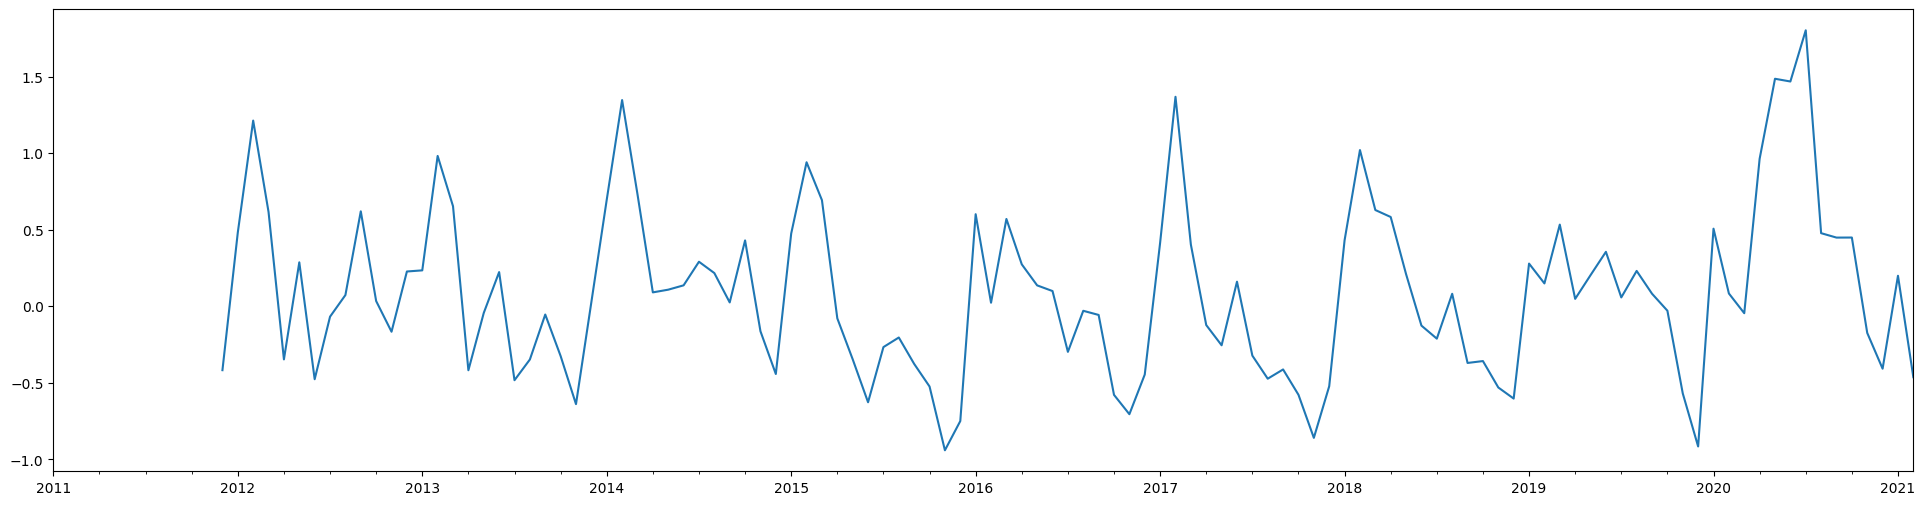

In [13]:
df2['unem-detrended'] = df2['Unemployment Rate'] - df2['MA-12-m']
df2['unem-detrended'].plot(figsize=(24,6))

### 3.3 Estimate the seasonal component

To estimate the seasonal component of the timeseries, a simple method of estimating the mean of each month is used and then combined seasonality of 12 consecutive months will give the seasonality. This is used due to the unemployment data's original sample being monthly data, as well as the seasonality in the series being sporatic. This behaviour has been seen from the yearly, mid yearly, and sometimes quarter yearly peaks and troughs. So it's been decided that a monthly grouping could better capture all the overlying seasonalities.

<Axes: >

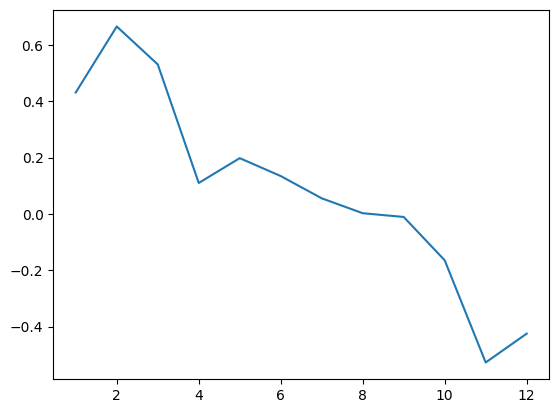

In [14]:
raw_monthly_avg = df2.groupby(df2.index.month)['unem-detrended'].mean()
raw_monthly_avg.plot()


This decomposition technique requires that the seasonality component sums to zero.

<Axes: >

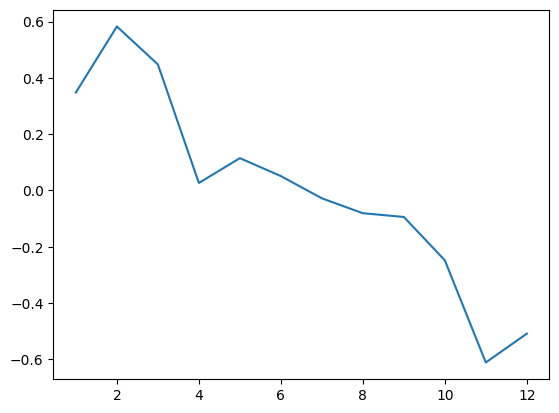

In [15]:
# Shift values so that the season components sum to zero
monthly_adjustment = raw_monthly_avg.sum()/12
monthly_avg = raw_monthly_avg - monthly_adjustment

monthly_avg.plot()

Now we can get this for the entire length of the orignal timeseries

122
122


<Axes: >

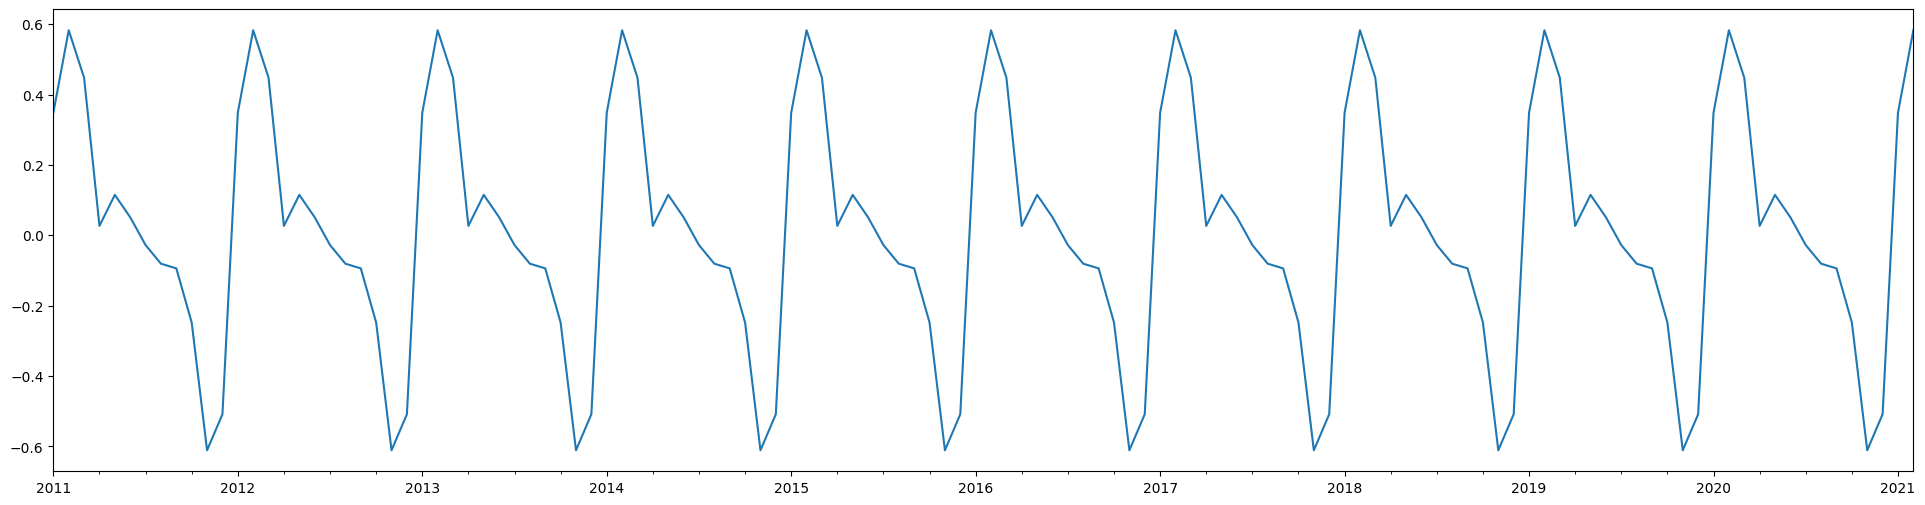

In [21]:
num_complete_cycles = (len(df2) // len(monthly_avg))
seasonal = np.tile(monthly_avg.values, num_complete_cycles)
remaining_months = len(df2) % len(monthly_avg)
seasonal = np.concatenate([seasonal, monthly_avg.values[:remaining_months]])

print(len(seasonal))
print(len(df2))

df2['unem-seasonal'] = seasonal
df2['unem-seasonal'].plot(figsize=(24,6))

From the estimation of the seasonal component in the unemployment data, there is a clear pattern throughout a year. This suggests that the seasonality is rather predictable every year for this dataset.

The peaks of the seasonality occur at start and near the middle of each month. This could be the impact of hiring cycles or some underlying economic events, including end of financial year and end-of-year holiday hiring/layoffs. There's this repetition of high unemployment rate at the beginning of the year which lowers leading up to mid year and repeats.

### 3.4 Calculate the residual component

The last step of STR decomposition is to calculate the residual. This is achieved by substracting the seasonal component from the de-trended data.

<Axes: >

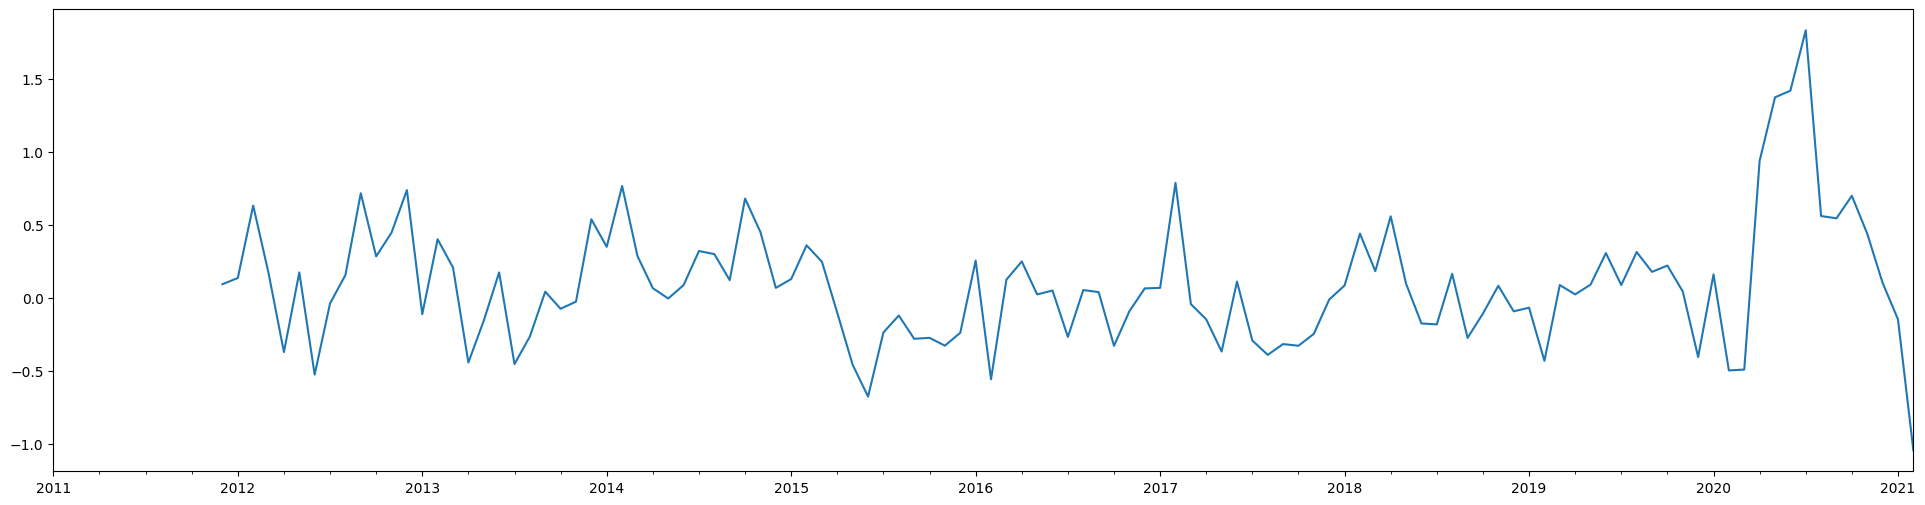

In [22]:
df2['unem-residual'] = df2['unem-detrended'] - df2['unem-seasonal']
df2['unem-residual'].plot(figsize=(24,6))

The residuals from my STR decomposition still has some seasonality remaining. It is believed that this is due to the variability of the seasonality in the time series data and not all of the seasonality could be estimated by the simplistic and manual STR decomposition above. This extra seasonality could be from the extra divots and peaks in the approximately quarterly period and below.

### 3.5 Putting all the plots on one figure

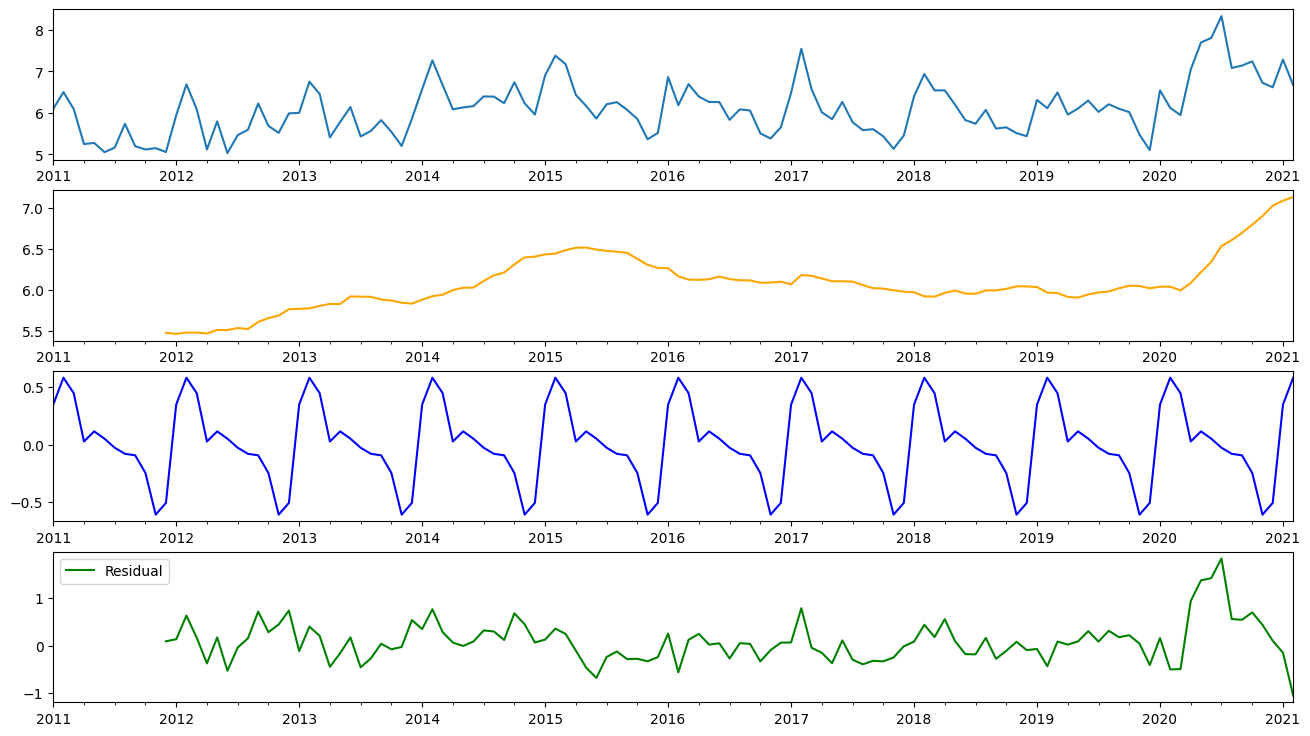

In [23]:
fig, ax_str = plt.subplots(4)
df2['Unemployment Rate'].plot(label='Original', ax=ax_str[0])
df2['MA-12-m'].plot(color='orange', label='MA-12-m Trend', ax=ax_str[1])
df2['unem-seasonal'].plot(color='blue', label='Seasonal', ax=ax_str[2])
df2['unem-residual'].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

### STR Decomposition using an Automated Model

To validate the output of the manual STR decomposition above, an automated model approach was used on the same data.

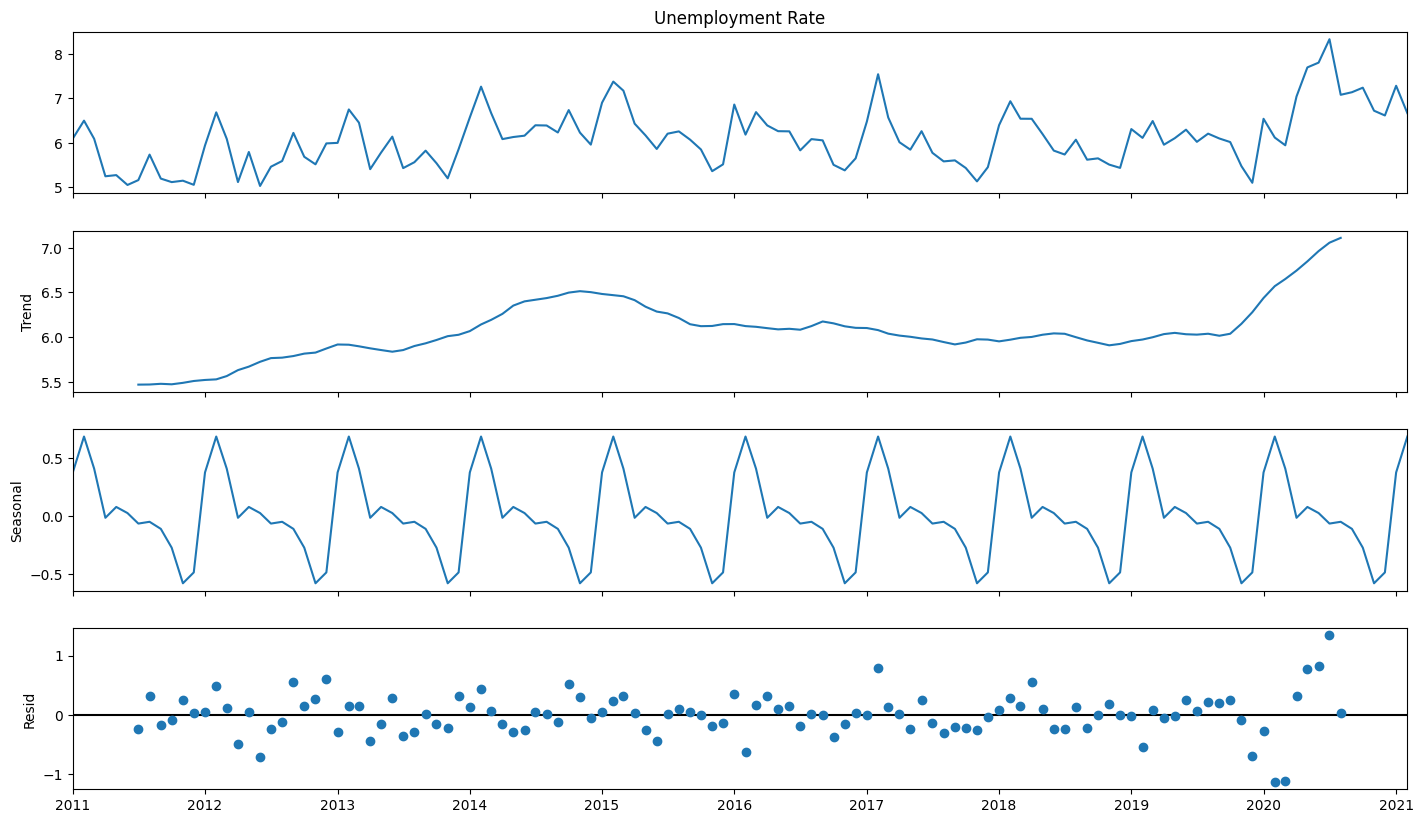

In [24]:
str_res = seasonal_decompose(df2['Unemployment Rate'],period = (12))
fig = str_res.plot()
fig.set_size_inches((16, 9))

The trend of the data has been captured fairly well. It appears the automated model also used a yearly moving average for the de-trending of the data. This approach was determined by the trial and error from the plots previously. Although this is an assumption as the model could've used a similar moving average window, however the trend is quite similar.

The seasonality was closely captured. Using the monthyl means has captured the start of year rise, and the end of year fall of unemployment rates. Althought, my seasonality estimate doesn't perfectly estimate the two mid year dips, it does show slight dips or slopes where those seasonal changes happen.

The residuals of my STR decomposition is also fairly similar. The residuals is closely followed as the seasonality and trend of my estimates match the statistical model.

Overall, my STR decomposition is pretty close to the automated model's version, and can be validated to be a good decomposition of the unemployment time series data.

# 4. Timeseries Models

### Fitting an ARIMA Model

An ARIMA model, or an AutoRegressive Integratd Moving Averages model, is a standard tool for modeling and forecasting (deseasonalised) time series data.

This model will be used for the forecasting and prediction of the time series data of this notebook.

#### 4.1 Checking for Stationarity

To fit an ARIMA model to our data we need to ensure that the AR component of an ARIMA model. Meaning that the data must be stationary. The basic and simplified definition of stationary data is:

- Constant Mean: the data is roughly horizontal.
- Constant Variance: the variability of the data around the mean remains stable over time, without significant fluctuations or changes in spread.
- No patterns predictable in the long-term.

We can check these for the unemployment data by looking at it's plot.

<Axes: >

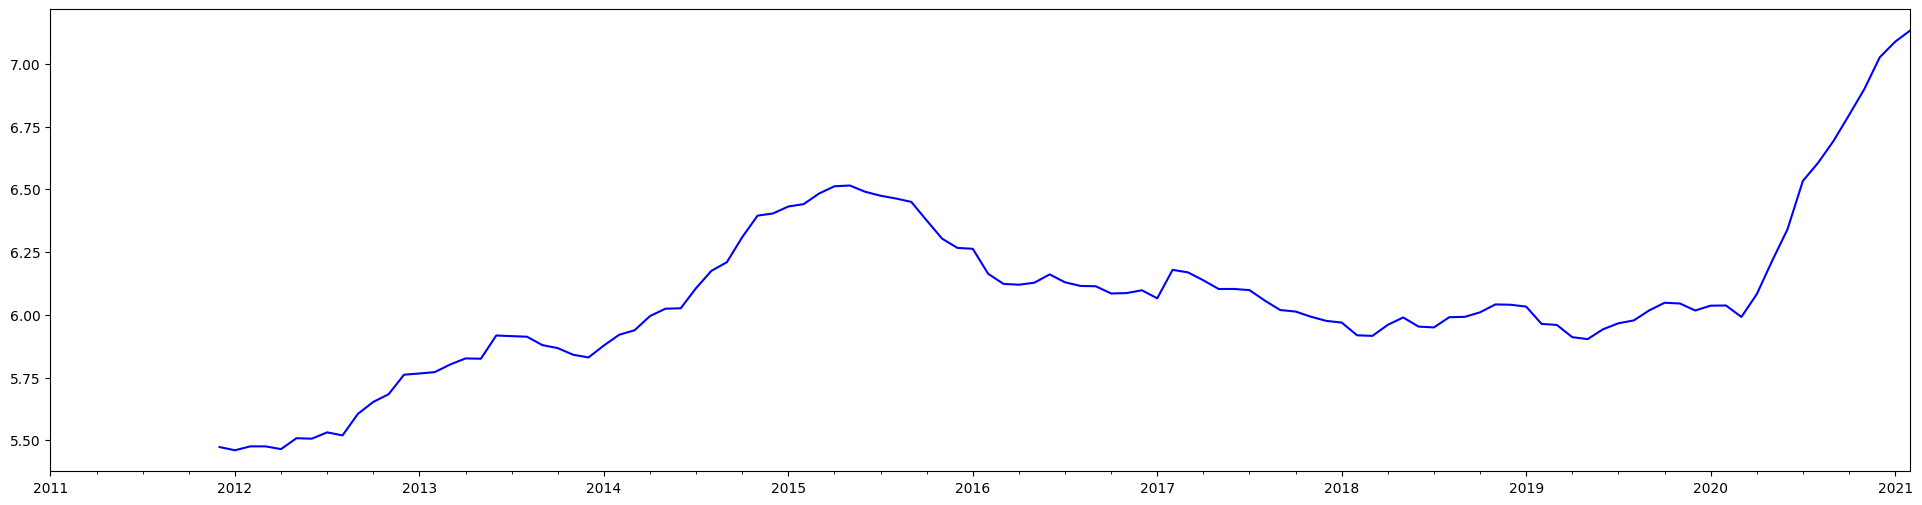

In [25]:
df2['MA-12-m'].plot(color='blue', figsize=(24, 6))

This is not stationary data, as there is a predictable pattern, changing variance, and the mean is not constant. To improve this, we can difference it. This step can be repeated multiple times until close to stationary data is observed.

To check whether the data is close to stationary, an Augmented Dickey-Fuller (ADF) test from the statsmodel library can be used.

<Axes: >

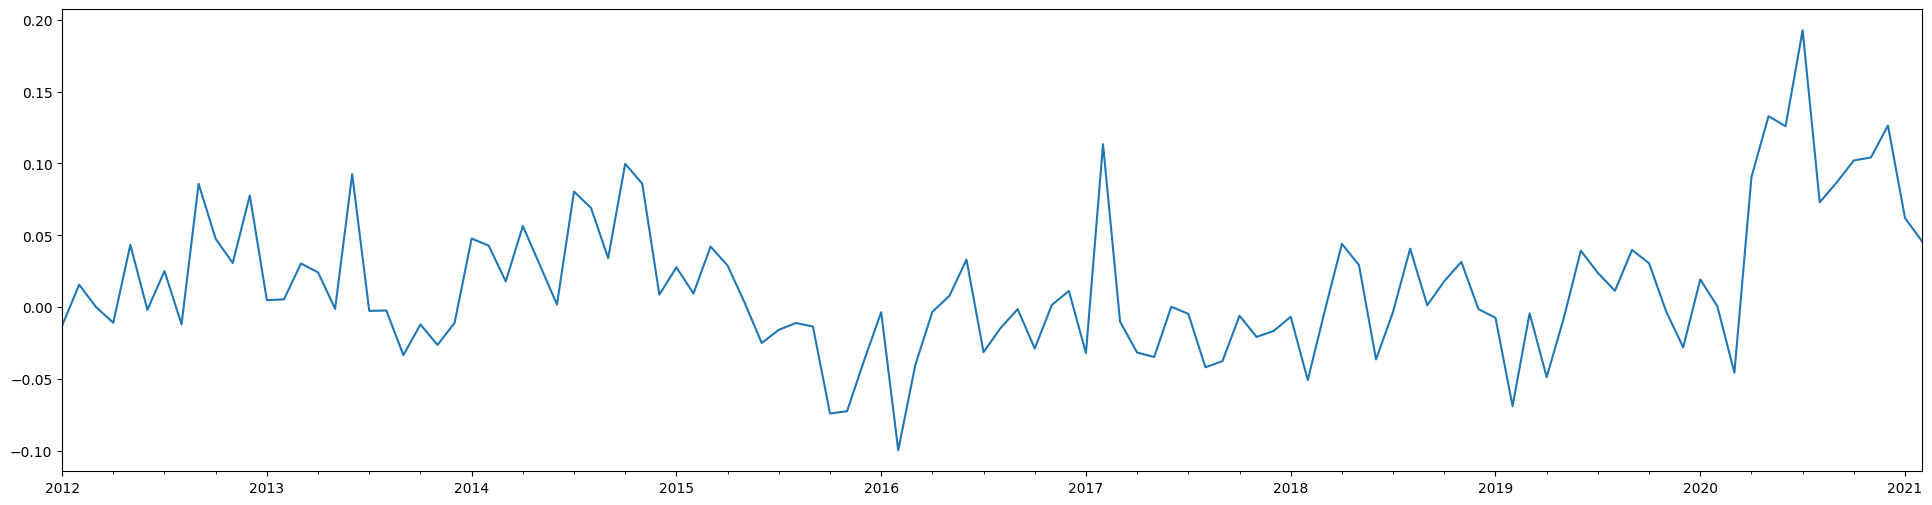

In [26]:
trend_d1 = df2['MA-12-m'].diff()
trend_d1 = trend_d1.dropna()
trend_d1.plot(figsize=(24,6))

In [27]:
result = adfuller(trend_d1)

print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -2.8044401509146786
p-value: 0.057642317887223994


The p-value is not close to or less than 0.05, so we difference the data again.

<Axes: >

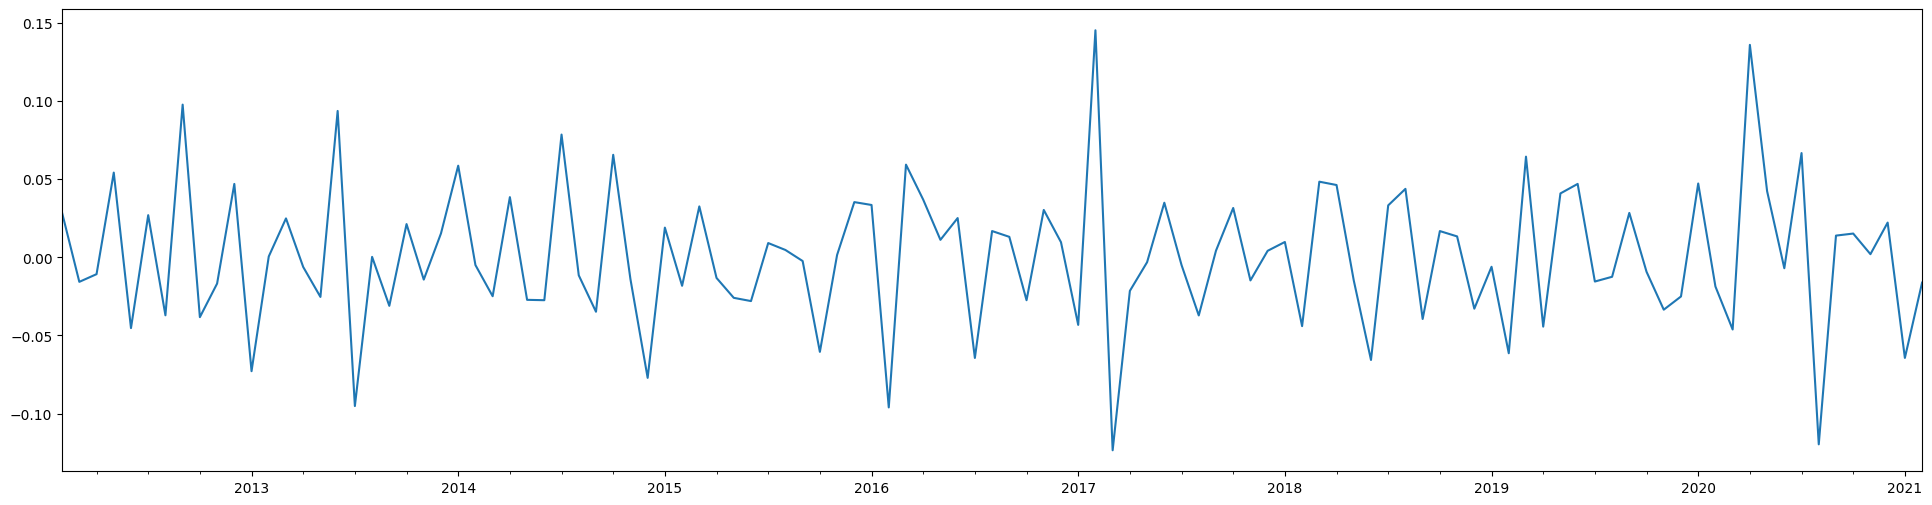

In [28]:
trend_d2 = trend_d1.diff()
trend_d2 = trend_d2.dropna()
trend_d2.plot(figsize=(24,6))

In [29]:
result = adfuller(trend_d2)

print('ADF Statistic:', result[0])
print(f"P-value: {result[1]:.2e}")

ADF Statistic: -3.9348212279354495
P-value: 1.79e-03


This p-value is well below 0.05, so this data can be interpreted as stationary.

#### 4.2 Fitting a lower order model

Now we can start the process of fitting an ARIMA model

#### 4.2.1 Evidence of Autocorrelation

Firstly, we check if there is evidence of autocorrelation in the data.

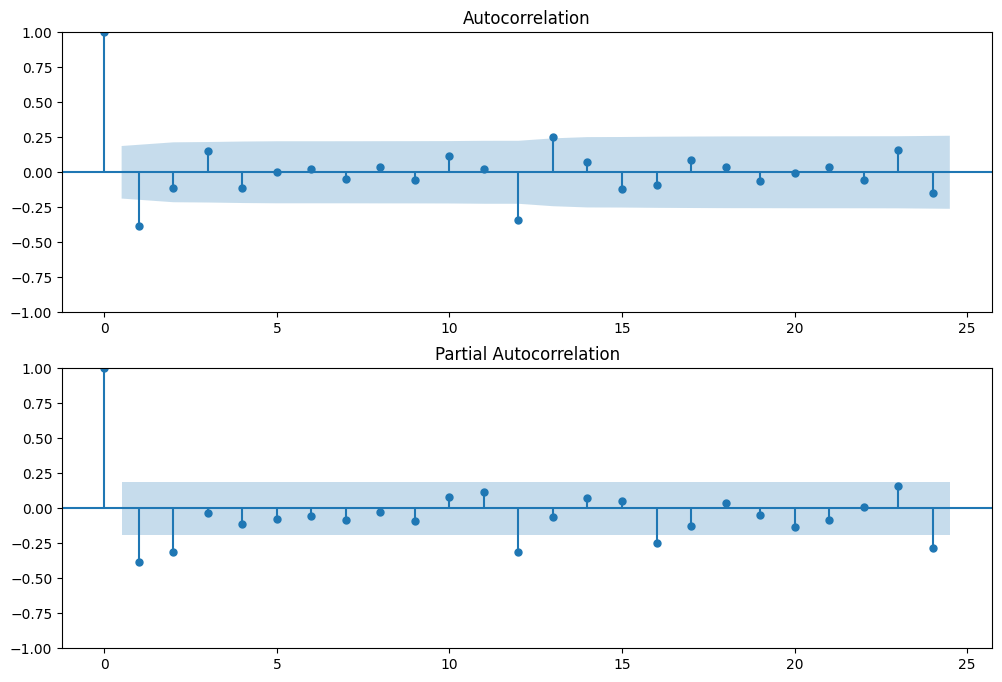

In [30]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d2, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d2, lags=24, ax=ax2)

The 2 differenced model is exactly what an ARIMA model need, with the exception of first lag point, the remaining points are either close to the confidence interval or within, and the data is quite horizontal.

#### 4.2.2 Fitting the ARIMA Model

Now that the data is stationary it can be modelled with an ARIMA process. This will start y using d=2 (from the number of differences on the series), p = 1, and q = 0.

In [31]:
arima_1_2_0 = ARIMA(df2['MA-12-m'], order=(1, 2, 0)).fit() # p, d, q
print(arima_1_2_0.summary())

                               SARIMAX Results                                
Dep. Variable:                MA-12-m   No. Observations:                  122
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 174.269
Date:                Wed, 23 Oct 2024   AIC                           -344.539
Time:                        09:12:13   BIC                           -338.964
Sample:                    01-01-2011   HQIC                          -342.275
                         - 02-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3868      0.073     -5.279      0.000      -0.530      -0.243
sigma2         0.0018      0.000      7.733      0.000       0.001       0.002
Ljung-Box (L1) (Q):                   1.80   Jarque-

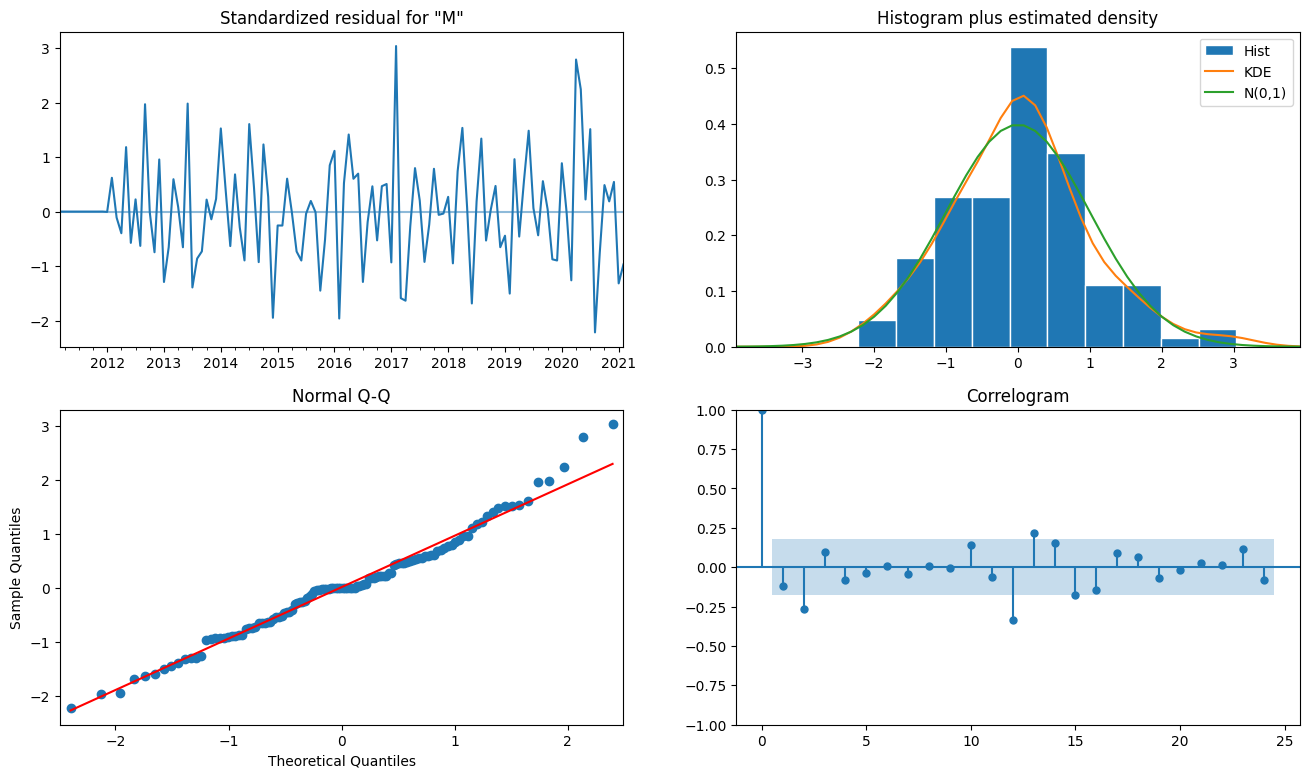

In [32]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_2_0.plot_diagnostics(fig=fig, lags=24)

#### 4.3 Fitting higher-order models

The ARIMA model will be improved by adjusting (increasing) the p and q parameters of the ARIMA model. Firstly incrementing p and then increment q one at a time. A good model will be used when the summary values of AIC, BIC, and HQIC do not significantly change and then the previous model will be used, also lower AIC, BIC and HQIC are preferred.

In [33]:
arima_2_2_0 = ARIMA(df2['MA-12-m'], order=(2, 2, 0)).fit() # p, d, q
print(arima_2_2_0.summary())

                               SARIMAX Results                                
Dep. Variable:                MA-12-m   No. Observations:                  122
Model:                 ARIMA(2, 2, 0)   Log Likelihood                 179.900
Date:                Wed, 23 Oct 2024   AIC                           -353.800
Time:                        09:12:14   BIC                           -345.438
Sample:                    01-01-2011   HQIC                          -350.404
                         - 02-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5118      0.075     -6.812      0.000      -0.659      -0.365
ar.L2         -0.3198      0.090     -3.560      0.000      -0.496      -0.144
sigma2         0.0016      0.000      7.834      0.0

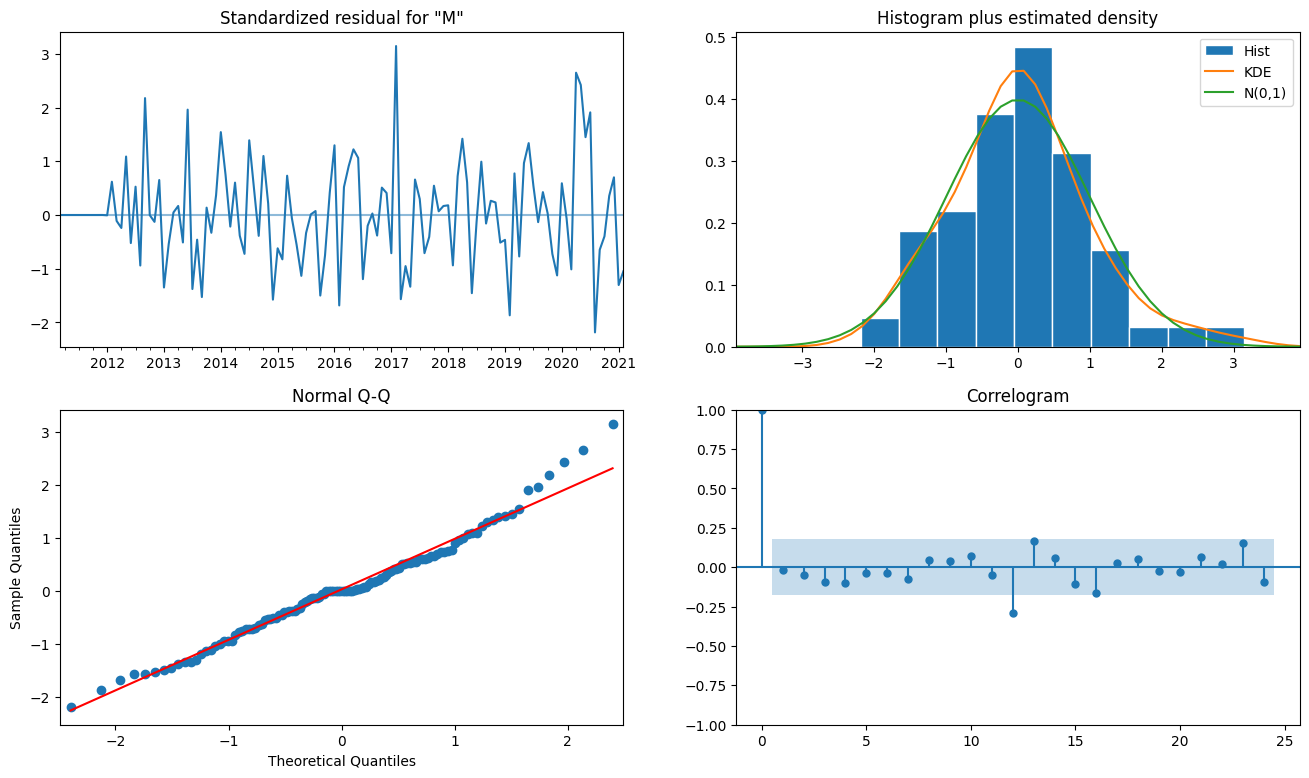

In [34]:
fig = plt.figure(figsize=(16, 9))
fig = arima_2_2_0.plot_diagnostics(fig=fig, lags=24)

In [35]:
arima_2_2_1 = ARIMA(df2['MA-12-m'], order=(2, 2, 1)).fit() # p, d, q
print(arima_2_2_1.summary())

                               SARIMAX Results                                
Dep. Variable:                MA-12-m   No. Observations:                  122
Model:                 ARIMA(2, 2, 1)   Log Likelihood                 180.061
Date:                Wed, 23 Oct 2024   AIC                           -352.121
Time:                        09:12:15   BIC                           -340.971
Sample:                    01-01-2011   HQIC                          -347.593
                         - 02-01-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3954      0.255     -1.550      0.121      -0.895       0.104
ar.L2         -0.2739      0.140     -1.961      0.050      -0.548      -0.000
ma.L1         -0.1297      0.254     -0.511      0.6

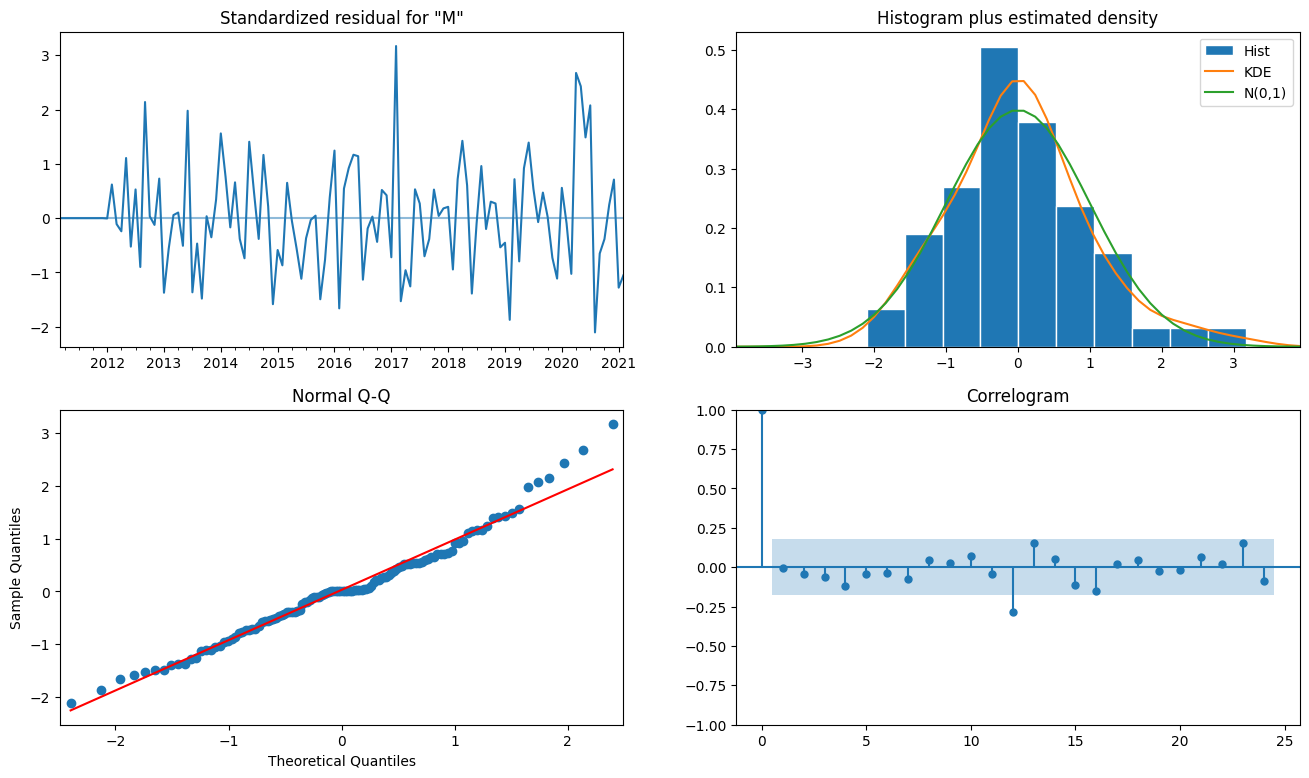

In [36]:
fig = plt.figure(figsize=(16, 9))
fig = arima_2_2_1.plot_diagnostics(fig=fig, lags=24)

The AIC, BIC, and HQIC are all better in model 2_2_1 and have not significantly changed. This means that arima model 2_2_1 will be used for the forecasting.

#### 4.4 Forecasting with ARIMA

In [37]:
arima_fcst = arima_2_2_1.get_forecast(steps=6) # for 6 months ahead
arima_predictions = pd.DataFrame(arima_fcst.predicted_mean)
arima_predictions.rename(columns={"predicted_mean": "trend"}, inplace=True)

#### 4.4.1 Mean trend prediction

A mean trend prediction predicts the next amount of steps in the future based off a predicted mean. This typically becomes a linear forecast, but is a necessary step for ARIMA forecasting.

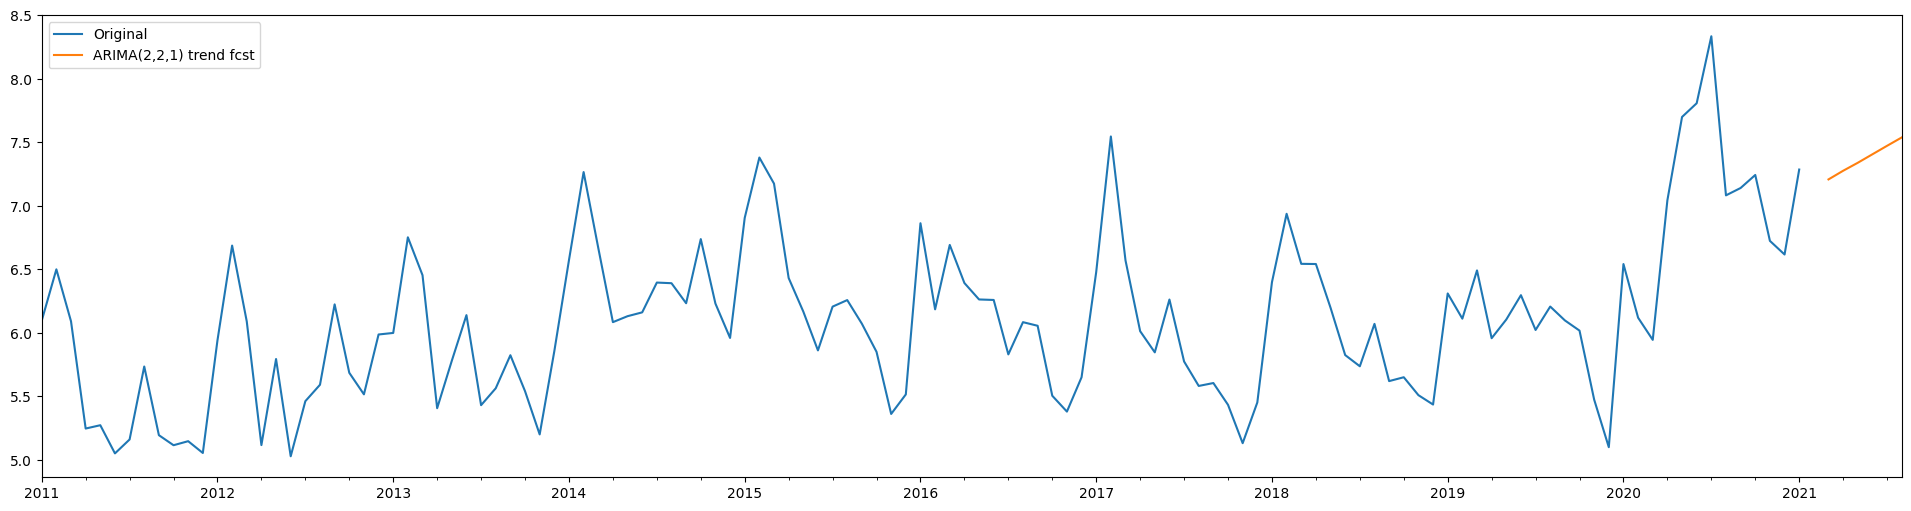

In [70]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df2[:'2021-01-01']['Unemployment Rate'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)
plt.legend()

# f_start="2020-12-01"
# f_end="2021-06-01"
# arima_fcst = arima_2_2_1.predict(start=f_start, end=f_end)
# arima_fcst.index = arima_fcst.index.astype('datetime64[ns]')
# fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
# df2[:"2020-12-01"]['Unemployment Rate'].plot(label='Original', ax=ax_arima_fcst)
# arima_fcst[f_start:f_end].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)

#### 4.4.2 Adding seasonality back into the forecasts

In [39]:
arima_predictions['seasonal'] = seasonal.tolist()[:len(arima_predictions)]
arima_predictions.head()

,trend,seasonal
2021-03-01,7.208807,0.348231
2021-04-01,7.276892,0.582602
2021-05-01,7.339758,0.447817
2021-06-01,7.406670,0.026559
2021-07-01,7.473412,0.114738


In [40]:
arima_predictions['trend+seasonal'] = arima_predictions['trend'] + arima_predictions['seasonal']
arima_predictions.head()

,trend,seasonal,trend+seasonal
2021-03-01,7.208807,0.348231,7.557038
2021-04-01,7.276892,0.582602,7.859494
2021-05-01,7.339758,0.447817,7.787574
2021-06-01,7.406670,0.026559,7.433229
2021-07-01,7.473412,0.114738,7.588150


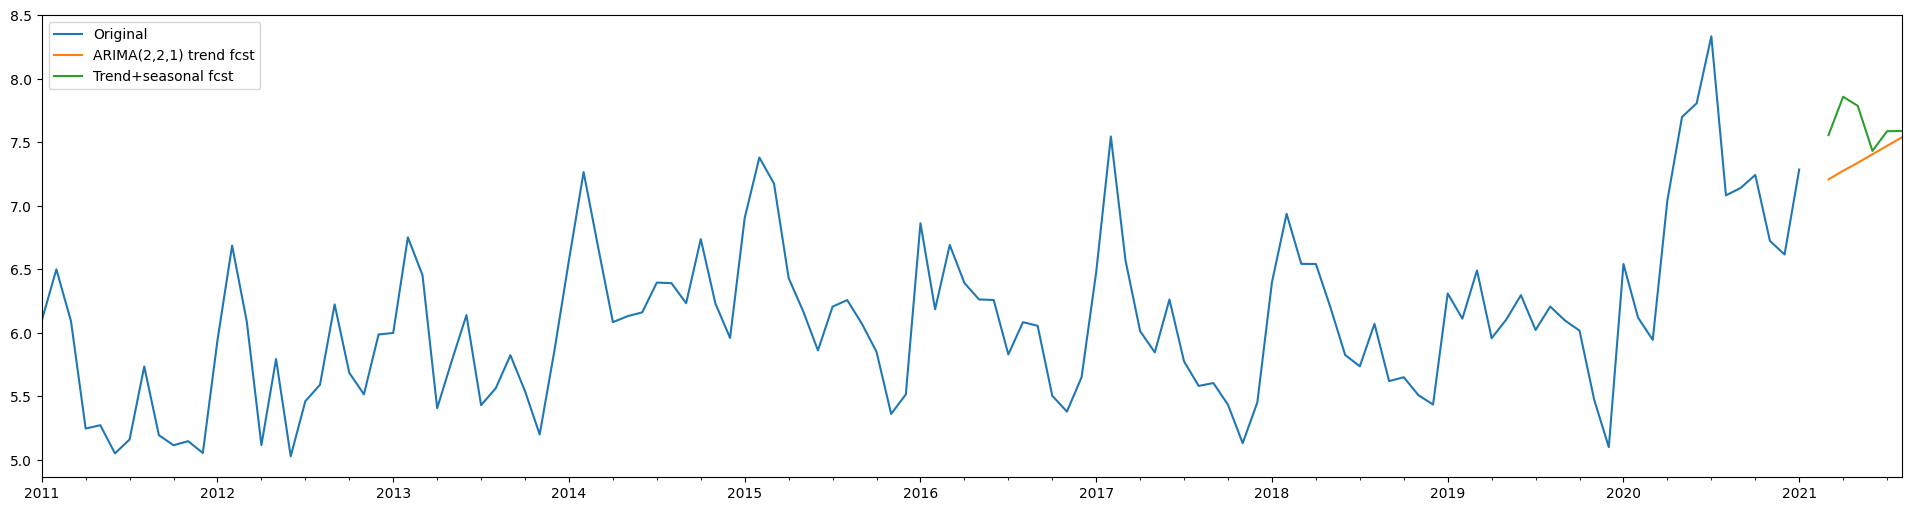

In [65]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df2[:'2021-01-01']['Unemployment Rate'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)
arima_predictions['trend+seasonal'].plot(label="Trend+seasonal fcst", ax=ax_arima_fcst)
plt.legend()

#### 4.4.3 Adding uncertainty to the forecast predictions

Confidence intervals for the trend-seasonal data can be done to give a better representation of the uncertainty within the mean trend prediction.

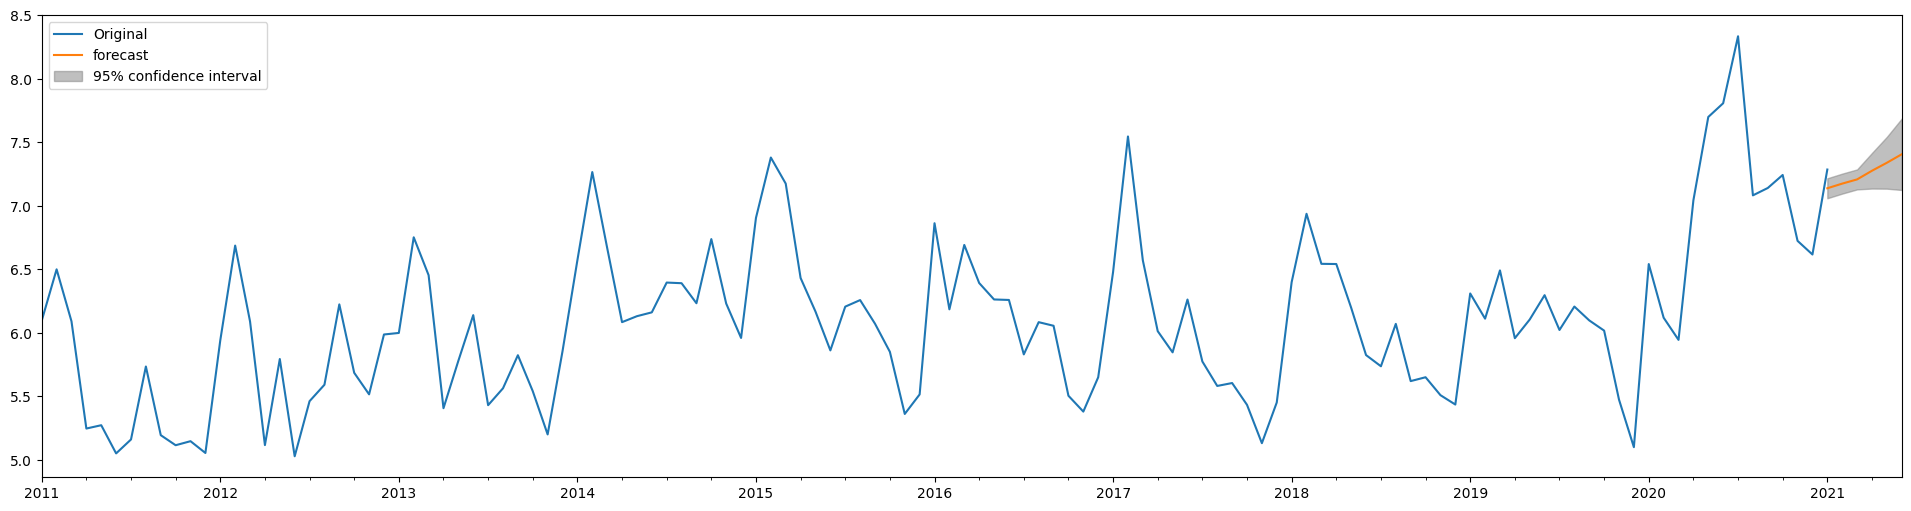

In [64]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df2[:'2021-01-01']['Unemployment Rate'].plot(label='Original', ax=ax_arima_fcst)
fig = plot_predict(arima_2_2_1,
                   start=pd.to_datetime("2021-01-01"), 
                   end=pd.to_datetime("2021-06-01"), 
                   ax=ax_arima_fcst)

In [43]:
arima_predictions = pd.concat([arima_predictions,arima_fcst.conf_int()], axis = 1)
arima_predictions.rename(columns={"lower MA-12-m": "trend lower CI", "upper MA-12-m": "trend upper CI"}, inplace=True)
arima_predictions["seasonal lower CI"] = arima_predictions["trend lower CI"] + arima_predictions['seasonal']
arima_predictions["seasonal upper CI"] = arima_predictions["trend upper CI"] + arima_predictions['seasonal']
arima_predictions.head()

,trend,seasonal,trend+seasonal,trend lower CI,trend upper CI,seasonal lower CI,seasonal upper CI
2021-03-01,7.208807,0.348231,7.557038,7.130172,7.287441,7.478403,7.635672
2021-04-01,7.276892,0.582602,7.859494,7.136773,7.417011,7.719375,7.999613
2021-05-01,7.339758,0.447817,7.787574,7.135873,7.543643,7.583690,7.991459
2021-06-01,7.406670,0.026559,7.433229,7.125506,7.687835,7.152064,7.714393
2021-07-01,7.473412,0.114738,7.588150,7.106811,7.840012,7.221550,7.954750


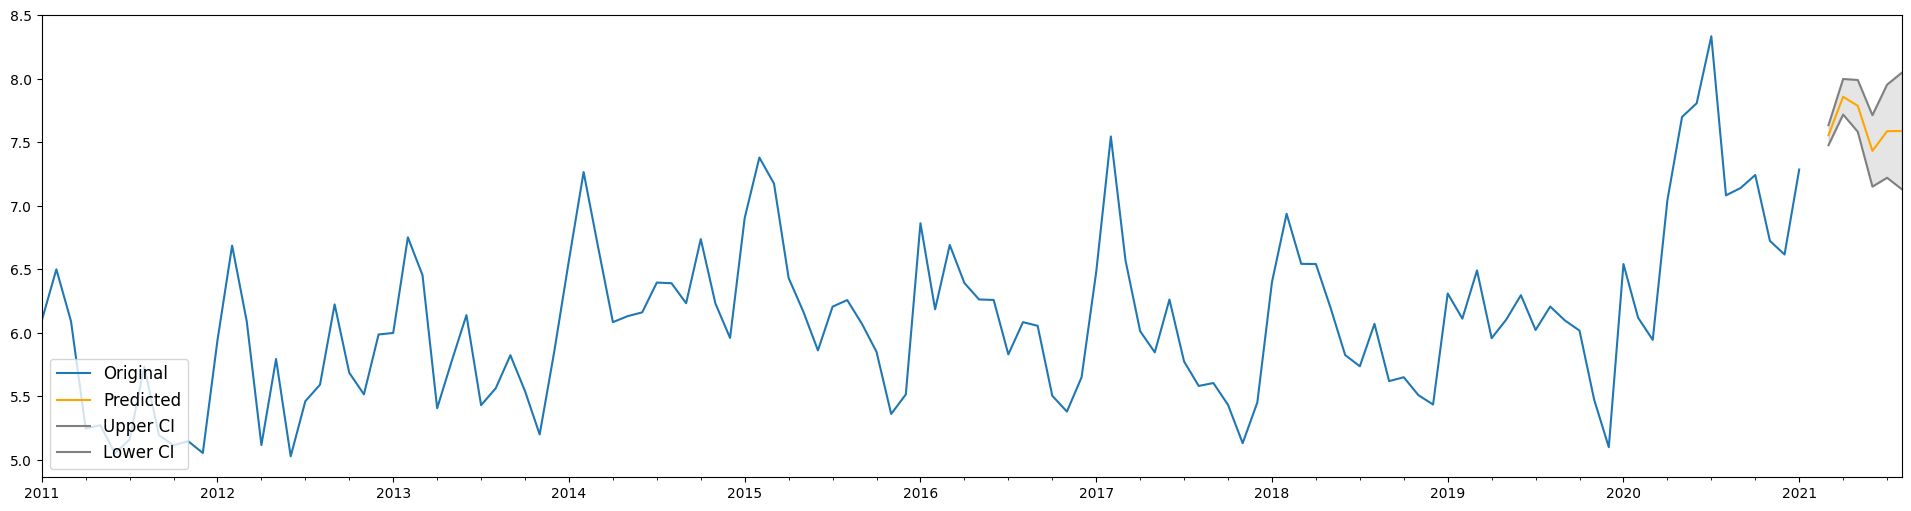

In [66]:
x = arima_predictions.index.values
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df2[:'2021-01-01']['Unemployment Rate'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend+seasonal'].plot(color = 'orange',label = 'Predicted' )
arima_predictions['seasonal upper CI'].plot(color = 'grey', label = 'Upper CI')
arima_predictions['seasonal lower CI'].plot(color = 'grey', label = 'Lower CI')

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)

# fill between the conf intervals
plt.fill_between(x, arima_predictions['seasonal lower CI'], arima_predictions['seasonal upper CI'], color='grey', alpha=0.2)

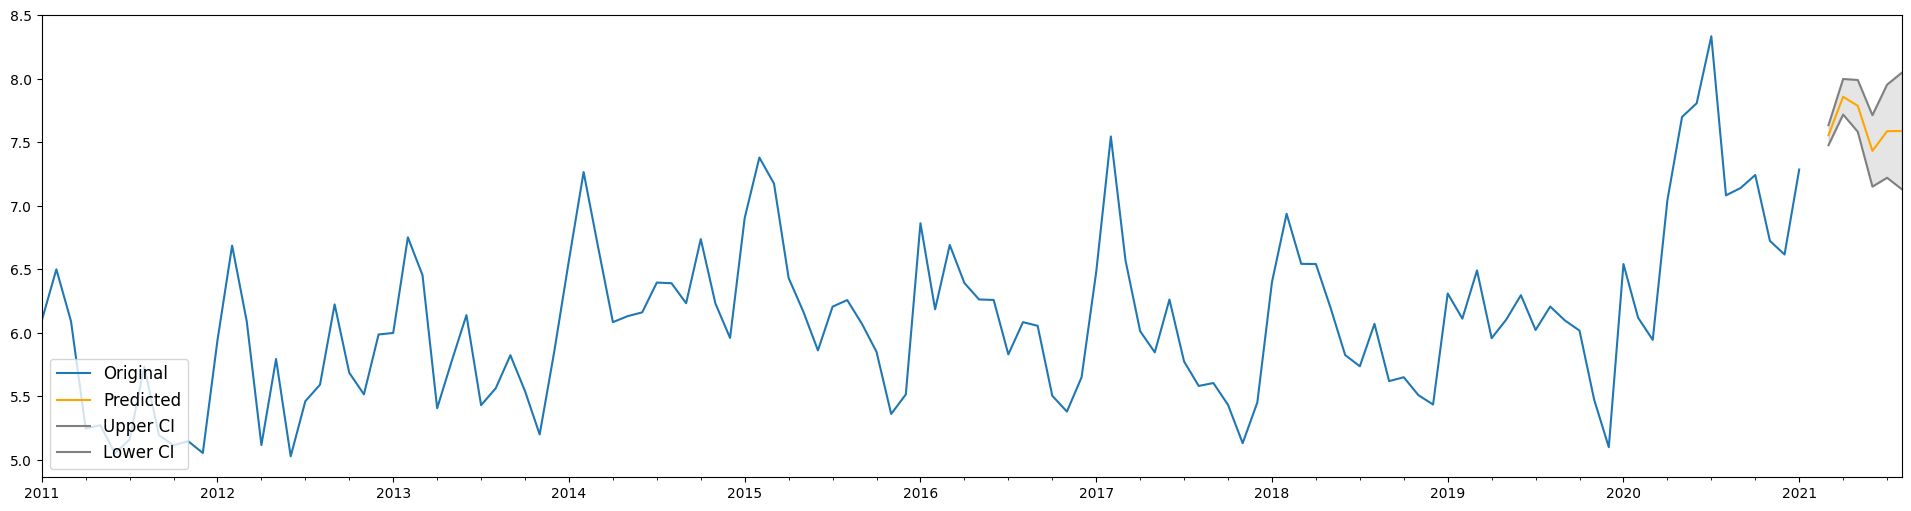

In [68]:
x = arima_predictions.index.values
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df2[:'2021-01-01']['Unemployment Rate'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend+seasonal'].plot(color = 'orange',label = 'Predicted' )
arima_predictions['seasonal upper CI'].plot(color = 'grey', label = 'Upper CI')
arima_predictions['seasonal lower CI'].plot(color = 'grey', label = 'Lower CI')

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)

# fill between the conf intervals
plt.fill_between(x, arima_predictions['seasonal lower CI'], arima_predictions['seasonal upper CI'], color='grey', alpha=0.2)

This is the predicted forecast for the next 6 months after at the beginning of 2021. The trend-seasonal prediction makes sense based off the seasonality and trends decomposed earlier in the STR section. The end of the trend has an upwards curve which has been captured in the arima prediction, a the seasonality that was manually estimated did show this rigid movement every 3-5 months.

As this forecast used the training data, the test data can be overlayed onto the plot, and a comparision can be made between the prediction and the actual forecast.

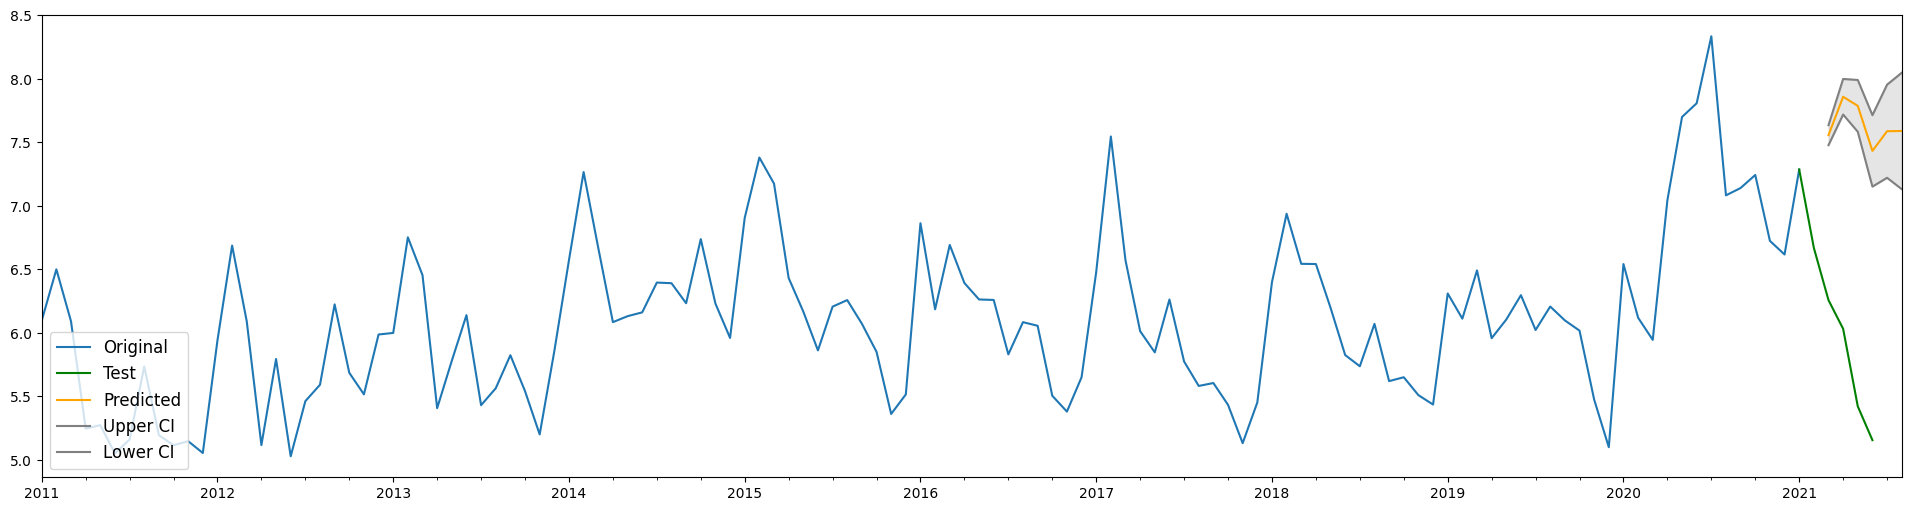

In [69]:
x = arima_predictions.index.values
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
df2[:'2021-01-01']['Unemployment Rate'].plot(label='Original', ax=ax_arima_fcst)
test_df['2021-01-01': '2021-06-30']['Unemployment Rate'].plot(label='Test', color = 'green')
arima_predictions['trend+seasonal'].plot(color = 'orange',label = 'Predicted' )
arima_predictions['seasonal upper CI'].plot(color = 'grey', label = 'Upper CI')
arima_predictions['seasonal lower CI'].plot(color = 'grey', label = 'Lower CI')

# plot the legend for the first plot
plt.legend(loc = 'lower left', fontsize = 12)

# fill between the conf intervals
plt.fill_between(x, arima_predictions['seasonal lower CI'], arima_predictions['seasonal upper CI'], color='grey', alpha=0.2)

The arima mean-trend prediction has not done an great job at forecasting 6 months head. This could be due to weaknesses in the STR decomposition as well as a weakness of using a mean-trend prediction, which is largely dependent on the characteristics of the data. When exploring the de-trended data line ('MA-12-m') the trend doesn't finish with the downwards curve. The test data for this dataset could itself be labelled as an outlier as there were global economic events that changed the trend, which this model wouldn't have been able to predict.

# 5. Pure Forecast: Using Neural Network Methods

Like mean-trend prediction, there are other methods to create these forecasts. One method involving the use of neural networks to forecast these timeseries datasets. The module tensorflow and keras is a popular neural network based method for forecasting timeseries data.

In [47]:
train = train_df.to_numpy()
test = test_df.to_numpy()

# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# training data
y_train = train_scaled[:,0]
X_train = train_scaled[:,1:]

# test data
y_test = test_scaled[:,0]
X_test = test_scaled[:,1:]

In [48]:
# Configure model
input_dim = X_train.shape[1]  # Number of lagged variables (features)
hidden_1_dim = 64 # number of nodes in hidden layer

# Single-layer FF network with Rectified linear unit (relu) activation fxn
inputs = keras.layers.Input(shape=(input_dim, ))
hidden_layer_1 = keras.layers.Dense(hidden_1_dim, activation='relu')(inputs)
outputs = keras.layers.Dense(1,activation='tanh')(hidden_layer_1)

model = keras.Model(inputs=inputs, outputs=outputs)

In [49]:
learning_rate = 0.001
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

#### 5.1.1 Training the network

In [50]:
# Fit
model.fit(X_train, y_train, epochs=12, batch_size=8, shuffle=False)

Epoch 1/12


2024-10-23 09:12:22.843806: W external/local_tsl/tsl/platform/profile_utils/cpu_utils.cc:118] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0407 
Epoch 2/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0372 
Epoch 3/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0382 
Epoch 4/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - loss: 0.0317
Epoch 5/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0279 
Epoch 6/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 0.0269
Epoch 7/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step - loss: 0.0266
Epoch 8/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 732us/step - loss: 0.0265
Epoch 9/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0264 
Epoch 10/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - loss: 0.0263
Epoch 11/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.02629
Epoch 12/12
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - loss: 0.0261


Now that the model has been trained using out training data we can begin predicting forecasts.

#### 5.1.2 Predictions

The first predictions that can be made using this forecaster will be on the trend component of the unemployment training data

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


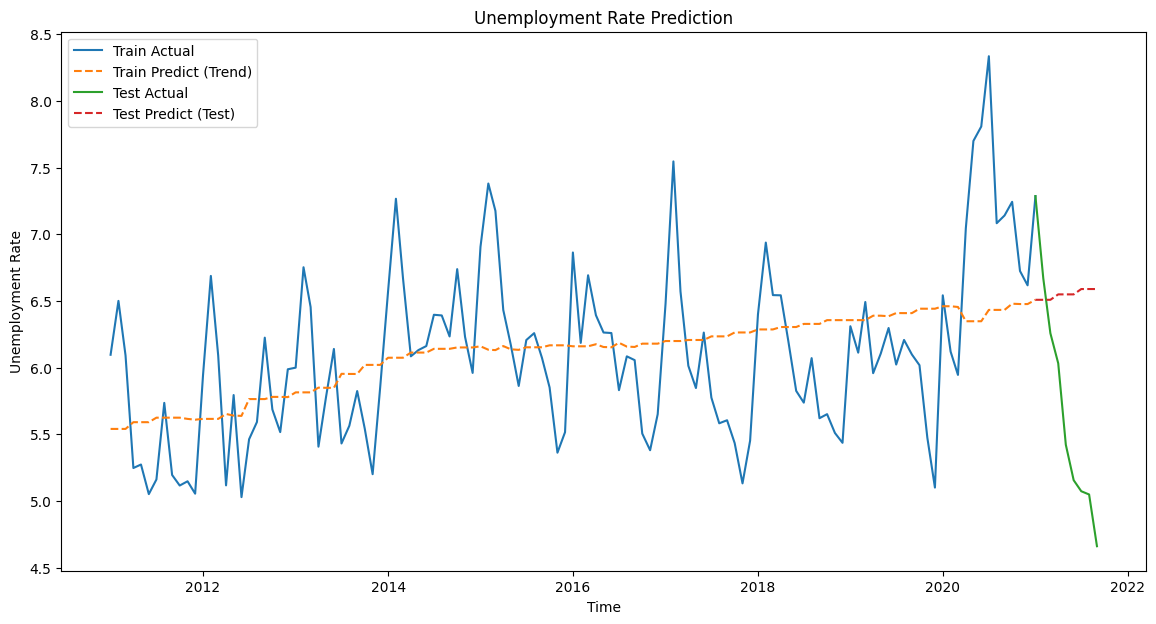

In [81]:
training_end_date = '2021-02-01'
training_end_date_index = df.index.get_loc(training_end_date)

test_start_date = '2021-01-01'
test_start_date_index = df.index.get_loc(test_start_date)


# forecasted_time = '2021-04-01'
months_ahead = 6
forecasted_time_index = df.index.get_loc(forecasted_time) + months_ahead

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform the predictions back to the orginal scale
train_predict = scaler.inverse_transform(np.concatenate((train_predict, X_train), axis=1))[:, 0]
test_predict = scaler.inverse_transform(np.concatenate((test_predict, X_test), axis=1))[:, 0]


# If there's a mismatch, trim the predictions to match the index length
if len(train_predict) > len(df.index[:training_end_date_index]):
    train_predict = train_predict[:len(df.index[:training_end_date_index])]

if len(test_predict) > len(df.index[test_start_date_index:forecasted_time_index]):
    test_predict = test_predict[:len(df.index[test_start_date_index:forecasted_time_index])]


plt.figure(figsize=(14, 7))
plt.plot(df.index[:training_end_date_index], df['Unemployment Rate'][:training_end_date_index], label='Train Actual')
plt.plot(df.index[:training_end_date_index], train_predict, label='Train Predict (Trend)', linestyle='dashed')
plt.plot(df.index[test_start_date_index:forecasted_time_index], df['Unemployment Rate'][test_start_date_index:forecasted_time_index], label='Test Actual')
plt.plot(df.index[test_start_date_index:forecasted_time_index], test_predict, label='Test Predict (Test)', linestyle='dashed')
plt.title('Unemployment Rate Prediction')
plt.xlabel('Time')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.show()

The trend prediction from the neural network has not forecasted the next 4 months well. However, the model has done it's best prediction based on the data trained on. This poor forecast would be due to the data, or the poor timeframe of the data as if any other period of the unemployment data was chosen to be forecast on this trend prediction could be better. Although, based on information from the training data (shown in yellow) the neural network based model has made it's best prediction given the data it has been trained on.

From a visual observation, the test actual data drops. This was due to unforeseen circumstances that the unemployment data cannot predict or hold, as this timeline can be associated with a global pandemic which did have unknown effects on the unemployment rate data,  meaning that this would be very difficult for a neural network being trained only on unemployment rates to predict.

Next with this prediction we can add the estimated seasonality back in from the STR decomposition to get another prediction of the data that isn't just the mean trend line.

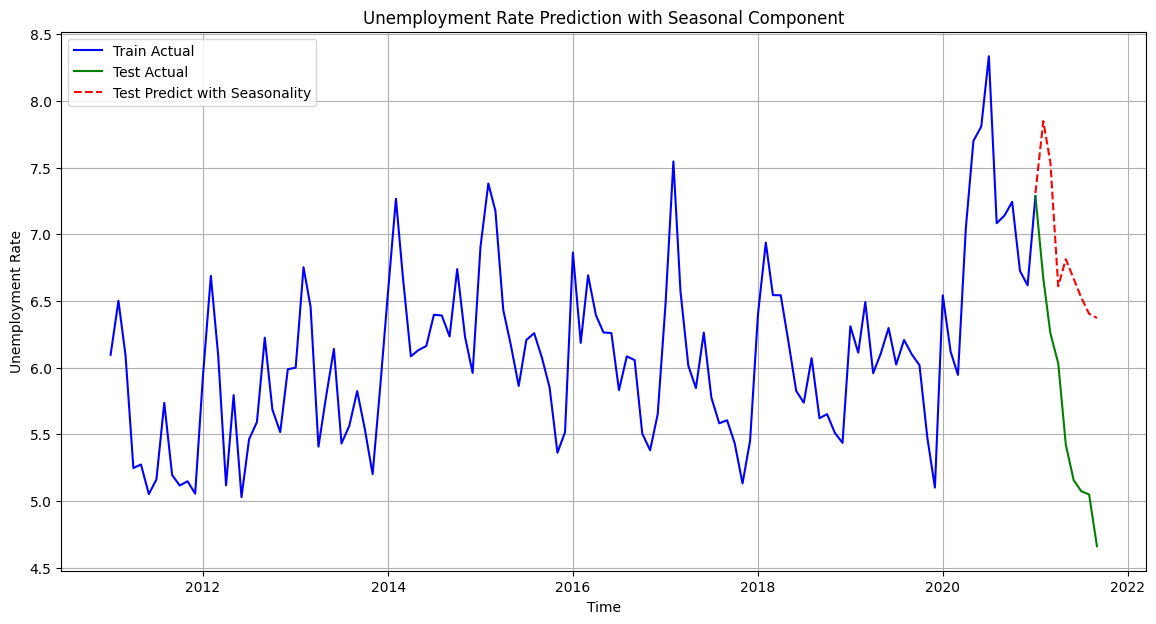

In [91]:
months_ahead = 6
forecasted_time_index = df.index.get_loc(forecasted_time) + months_ahead

seasonal_values_train = df2['unem-seasonal'][:training_end_date_index]

# Create seasonal values for test data
season_length = len(seasonal_values_train)
test_seasonality = np.tile(seasonal_values_train.values, (len(test_predict) // season_length + 1))[:len(test_predict)]

# Combine predictions for training and testing
train_predictions_with_seasonality = train_predict + seasonal_values_train.values
scaling_factor = 2.3
test_predictions_with_seasonality = test_predict.flatten() + test_seasonality * scaling_factor

# Plotting all components
plt.figure(figsize=(14, 7))

# Plot training actuals and predictions
plt.plot(df.index[:training_end_date_index], df['Unemployment Rate'][:training_end_date_index], 
         label='Train Actual', color='blue')
# Plot test actuals and predictions
plt.plot(df.index[test_start_date_index:forecasted_time_index], df['Unemployment Rate'][test_start_date_index:forecasted_time_index], 
         label='Test Actual', color='green')
plt.plot(df.index[test_start_date_index:forecasted_time_index], test_predictions_with_seasonality, 
         label='Test Predict with Seasonality', linestyle='dashed', color='red')

# Titles and labels
plt.title('Unemployment Rate Prediction with Seasonal Component')
plt.xlabel('Time')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid()
plt.show()

Now adding the uncertainty and confidence intervals into the forecasted plot to get an understanding of the where the model believes the data could go.

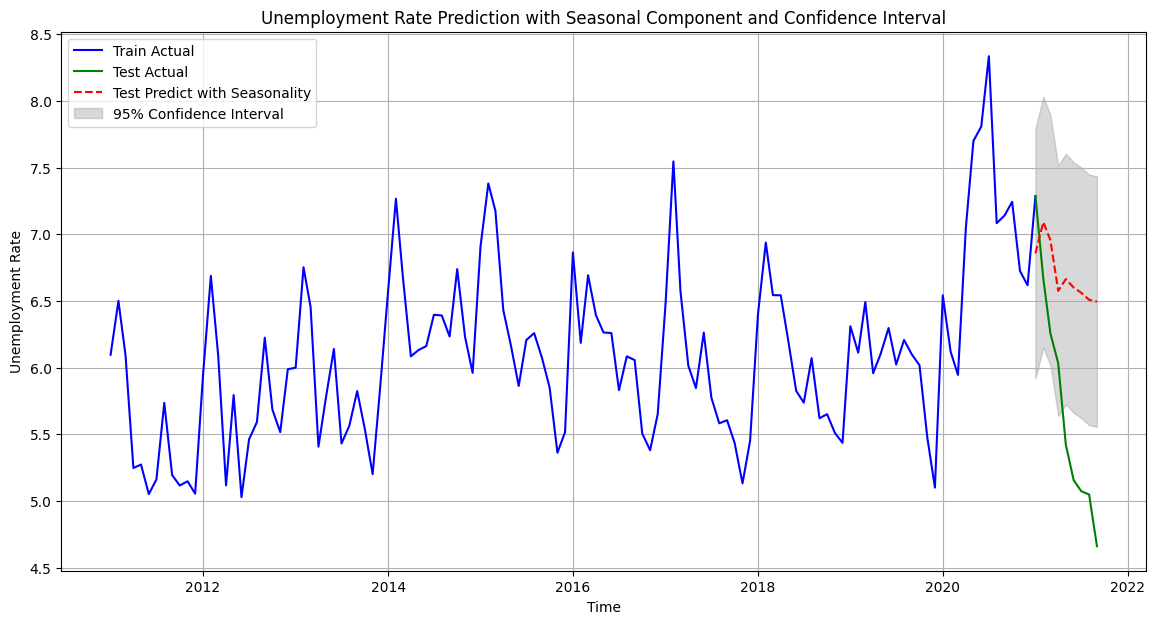

In [87]:
residuals = df['Unemployment Rate'][:training_end_date_index] - train_predictions_with_seasonality
std_dev = np.std(residuals)
ci_multiplier = 1.96
confidence_interval = ci_multiplier * std_dev

upper_bound = test_predictions_with_seasonality + confidence_interval
lower_bound = test_predictions_with_seasonality - confidence_interval

# Plotting all components
plt.figure(figsize=(14, 7))

# Plot training actuals and predictions
plt.plot(df.index[:training_end_date_index], df['Unemployment Rate'][:training_end_date_index], 
         label='Train Actual', color='blue')

# Plot test actuals and predictions
plt.plot(df.index[test_start_date_index:forecasted_time_index], df['Unemployment Rate'][test_start_date_index:forecasted_time_index], 
         label='Test Actual', color='green')
plt.plot(df.index[test_start_date_index:forecasted_time_index], test_predictions_with_seasonality, 
         label='Test Predict with Seasonality', linestyle='dashed', color='red')

# Plot confidence intervals as a shaded area
plt.fill_between(df.index[test_start_date_index:forecasted_time_index], lower_bound, upper_bound, 
                 color='gray', alpha=0.3, label='95% Confidence Interval')

# Titles and labels
plt.title('Unemployment Rate Prediction with Seasonal Component and Confidence Interval')
plt.xlabel('Time')
plt.ylabel('Unemployment Rate')
plt.legend()
plt.grid()
plt.show()


When introducing seasonality back into our prediction, the model shows a little better forecast of what the data would look like. From the previously explored seasonality decomposition, it is quite uniform to see a large spike of unemployment rate at the end of the eyar following by a large drop. The model has forecast this well given the data continues this pattern, however due to the nature of the data and this period the 4 months forecast does not match the actual data.

Looking at the confidence intervals to show the possible uncertainty within the forecast, the uncertainty is quite large. This could be due to the data overfitting to the training data, or having trained this network on insufficient data. The current unemployment dataset has focused on 2011 to 2023, with 2021 to 2023 being the test data, leaving 10 years of training data and 120 data points (when sampled to monthly). This is not a significant amount of data and could have led to overfitting of the data and could possible have missed or lost larger forms of seasonality or trends. This coupled with the fact that the test and training data are split around the start of a pandemic has made both datasets quite different, which does make it hard for a neural network prediction, that has possible overfit, to predict and forecast the unemployment data.